In [1]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook



%matplotlib inline

In [2]:
df = pd.read_csv("exchange_rates.csv", index_col=['Time Period'],skiprows=range(5),parse_dates=['Time Period'])

In [3]:
df.head()

RXI$US_N.B.EU RXI$US_N.B.UK RXI_N.B.BZ RXI_N.B.CH RXI_N.B.DN  \
Time Period                                                                
1971-01-04            NaN        2.3938        NaN        NaN     7.4850   
1971-01-05            NaN        2.3949        NaN        NaN     7.4872   
1971-01-06            NaN        2.3967        NaN        NaN     7.4839   
1971-01-07            NaN        2.3963        NaN        NaN     7.4850   
1971-01-08            NaN        2.3972        NaN        NaN     7.4850   

            RXI_N.B.IN RXI_N.B.JA RXI_N.B.KO RXI_N.B.MA RXI_N.B.MX  ...  \
Time Period                                                         ...   
1971-01-04         NaN   357.7300        NaN     3.0867        NaN  ...   
1971-01-05         NaN   357.8100        NaN     3.0861        NaN  ...   
1971-01-06         NaN   357.8600        NaN     3.0845        NaN  ...   
1971-01-07         NaN   357.8700        NaN     3.0850        NaN  ...   
1971-01-08         NaN   357.8200        NaN     3.0845        NaN  ...   

            RXI_N.B.TH RXI_N.B.VE JRXWTFB_N.B JRXWTFN_N.B JRXWTFO_N.B  \
Time Period                                                             
1971-01-04         NaN        NaN         NaN         NaN         NaN   
1971-01-05         NaN        NaN         NaN         NaN         NaN   
1971-01-06         NaN        NaN         NaN         NaN         NaN   
1971-01-07         NaN        NaN         NaN         NaN         NaN   
1971-01-08         NaN        NaN         NaN         NaN         NaN   

            RXI$US_N.B.AL RXI$US_N.B.NZ RXI_N.B.CA RXI_N.B.HK RXI_N.B.SL  
Time Period                                                               
1971-01-04         1.1127        1.1138     1.0109        NaN        NaN  
1971-01-05         1.1132        1.1143     1.0102        NaN        NaN  
1971-01-06         1.1140        1.1151     1.0106        NaN        NaN  
1971-01-07         1.1138        1.1150     1.0148        NaN        NaN  
1971-01-08         1.1124        1.1154     1.0154        NaN        NaN  

[5 rows x 26 columns]

In [4]:
df_rate = df.loc[(df['RXI$US_N.B.UK'] != 'ND'), ['RXI$US_N.B.UK']]

In [5]:
df_rate.rename(columns={'RXI$US_N.B.UK':'GBP_RATE'}, inplace=True)

In [6]:
df_rate.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11709 entries, 1971-01-04 to 2017-08-25
Data columns (total 1 columns):
GBP_RATE    11709 non-null object
dtypes: object(1)
memory usage: 183.0+ KB


In [7]:
df_rate['GBP_RATE'] = df_rate['GBP_RATE'].astype(float)

In [8]:
df_rate[df_rate.GBP_RATE =='ND'].count()

GBP_RATE    0
dtype: int64

type(df_rate)

In [10]:
df_rate.head()

GBP_RATE
Time Period          
1971-01-04     2.3938
1971-01-05     2.3949
1971-01-06     2.3967
1971-01-07     2.3963
1971-01-08     2.3972

### 1. EDA (EXPLORATION DATA ANALYTIC)

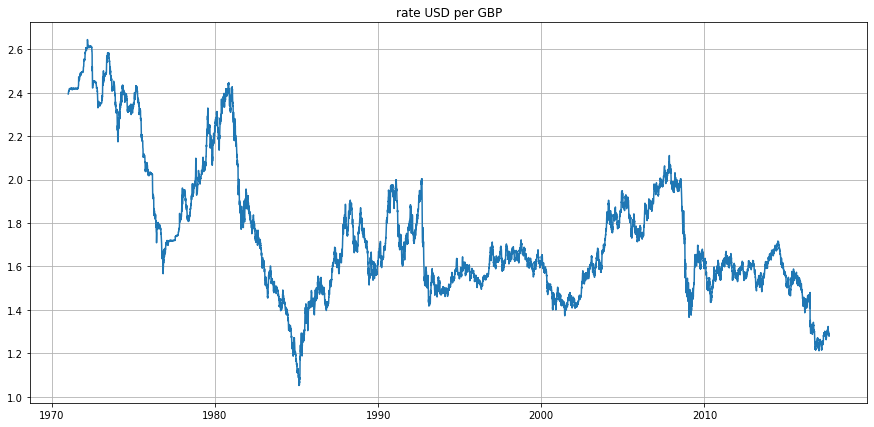

In [11]:
plt.figure(figsize=(15, 7))
plt.plot(df_rate.GBP_RATE)
plt.title('rate USD per GBP')
plt.grid(True)
plt.show()

In [12]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

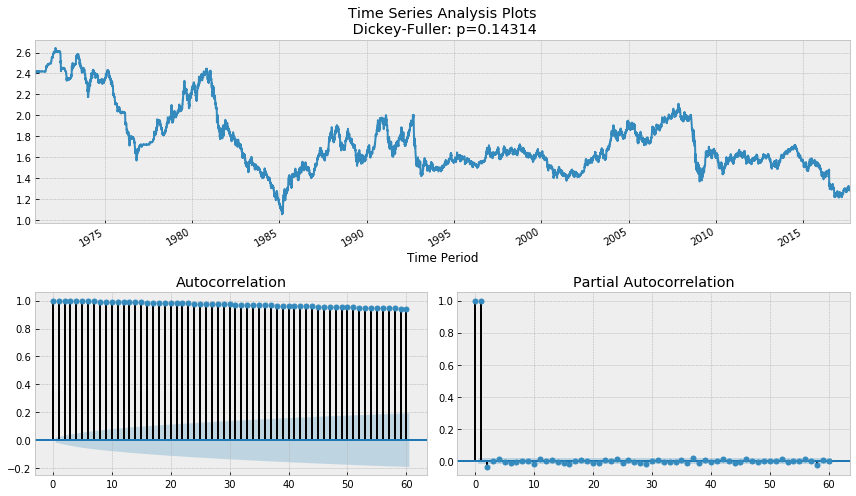

In [13]:
tsplot(df_rate.GBP_RATE, lags=60)

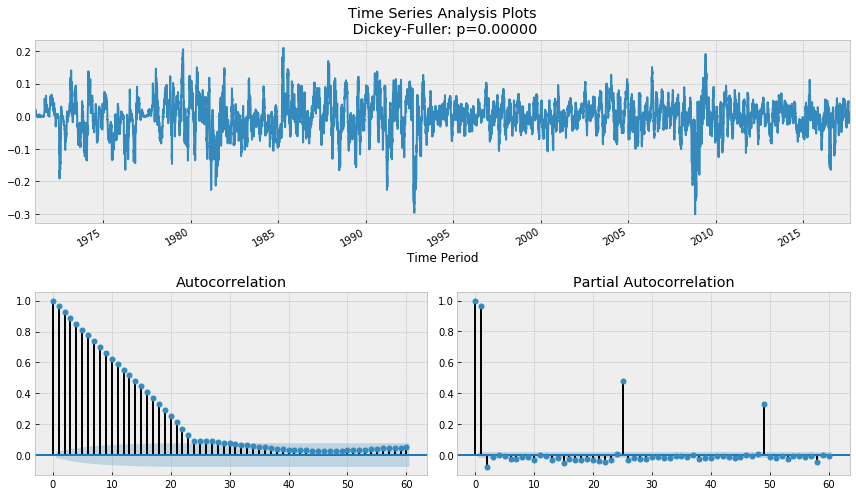

In [14]:
ads_diff = df_rate.GBP_RATE - df_rate.GBP_RATE.shift(24)
tsplot(ads_diff[24:], lags=60)

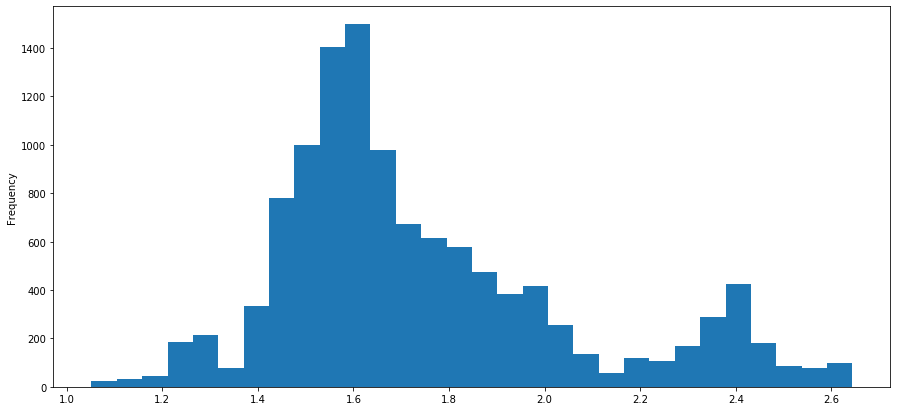

In [15]:
df_rate.GBP_RATE.plot(kind = "hist",figsize=(15, 7), bins = 30)

In [16]:
df_rate['GBP_RATE_LOG'] = np.log(df_rate.GBP_RATE)
df_rate.head()

GBP_RATE  GBP_RATE_LOG
Time Period                        
1971-01-04     2.3938      0.872882
1971-01-05     2.3949      0.873341
1971-01-06     2.3967      0.874093
1971-01-07     2.3963      0.873926
1971-01-08     2.3972      0.874301

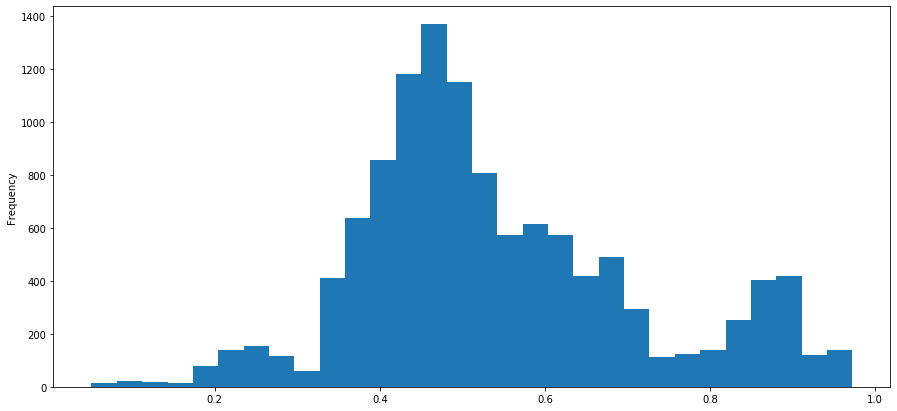

In [17]:
df_rate.GBP_RATE_LOG.plot(kind = "hist",figsize=(15, 7), bins = 30)

In [18]:
model_mean_pred = df_rate.GBP_RATE_LOG.mean()

In [19]:
# Let us store this as our Mean Predication Value
df_rate["GBP_RATE_MEAN"] = np.exp(model_mean_pred)

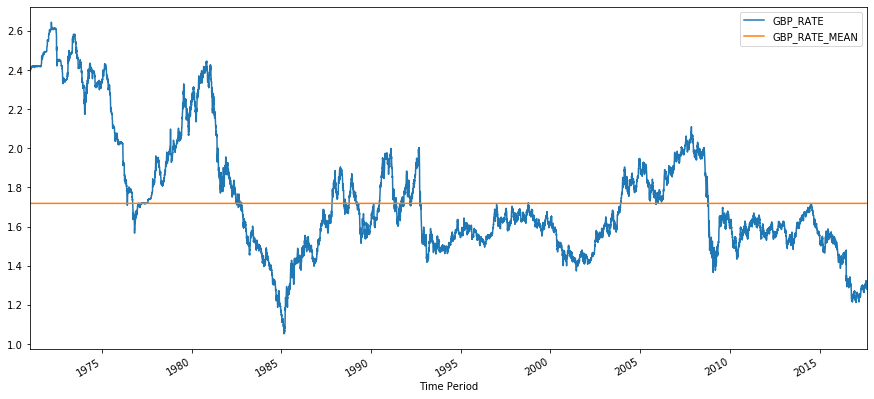

In [20]:
df_rate.plot(kind="line",figsize=(15, 7), y = ["GBP_RATE", "GBP_RATE_MEAN"])

In [21]:
def RMSE(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

In [22]:
model_mean_RMSE = RMSE(df_rate.GBP_RATE_MEAN, df_rate.GBP_RATE)
model_mean_RMSE

0.31403273057753284

In [23]:
# Save this in a dataframe
dfResults = pd.DataFrame(columns = ["Model", "Forecast", "RMSE"])
dfResults.head()

Empty DataFrame
Columns: [Model, Forecast, RMSE]
Index: []

In [24]:
dfResults.loc[0,"Model"] = "Mean"
dfResults.loc[0,"Forecast"] = np.exp(model_mean_pred)
dfResults.loc[0,"RMSE"] = model_mean_RMSE
dfResults.head()

Model Forecast      RMSE
0  Mean  1.71847  0.314033

In [25]:
df_rate.head()

GBP_RATE  GBP_RATE_LOG  GBP_RATE_MEAN
Time Period                                       
1971-01-04     2.3938      0.872882        1.71847
1971-01-05     2.3949      0.873341        1.71847
1971-01-06     2.3967      0.874093        1.71847
1971-01-07     2.3963      0.873926        1.71847
1971-01-08     2.3972      0.874301        1.71847

In [26]:
df_rate.dtypes

GBP_RATE         float64
GBP_RATE_LOG     float64
GBP_RATE_MEAN    float64
dtype: object

In [27]:
df_rate['date'] = df_rate.index

In [28]:
df_rate.date.min()

Timestamp('1971-01-04 00:00:00')

In [29]:
# Convert date in datetimedelta figure starting from zero
df_rate["timeIndex"] = df_rate.date - df_rate.date.min()

In [30]:
# Convert to months using the timedelta function
df_rate["timeIndex"] =  df_rate["timeIndex"]/np.timedelta64(1, 'M')

In [31]:
df_rate.timeIndex.head()

Time Period
1971-01-04    0.000000
1971-01-05    0.032855
1971-01-06    0.065710
1971-01-07    0.098565
1971-01-08    0.131420
Name: timeIndex, dtype: float64

In [32]:
# Round the number to 0
df_rate["timeIndex"] = df_rate["timeIndex"].round(0).astype(int)

In [33]:
df_rate.timeIndex.tail()

Time Period
2017-08-21    560
2017-08-22    560
2017-08-23    560
2017-08-24    560
2017-08-25    560
Name: timeIndex, dtype: int32

In [34]:
## Now plot linear regression between priceMod and timeIndex
model_linear = smf.ols('GBP_RATE_LOG ~ timeIndex', data = df_rate).fit()

In [35]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           GBP_RATE_LOG   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     5134.
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:04:41   Log-Likelihood:                 6239.8
No. Observations:               11709   AIC:                        -1.248e+04
Df Residuals:                   11707   BIC:                        -1.246e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7046      0.003    268.100      0.000       0.699       0.710
timeIndex     -0.0006   8.13e-06    -71.654      0.000      -0.001      -0.001
==============================================================================
Omnibus:                      216.305   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              232.667
Skew:                          -0.318   Prob(JB):                     3.00e-51
Kurtosis:                       3.270   Cond. No.                         647.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
## Parameters for y = mx + c equation
model_linear.params

Intercept    0.704579
timeIndex   -0.000582
dtype: float64

In [37]:
c = model_linear.params[0]
c

0.7045785383102379

In [38]:
m = model_linear.params[1]
m

-0.000582451222413376

In [39]:
model_linear_pred = model_linear.predict()

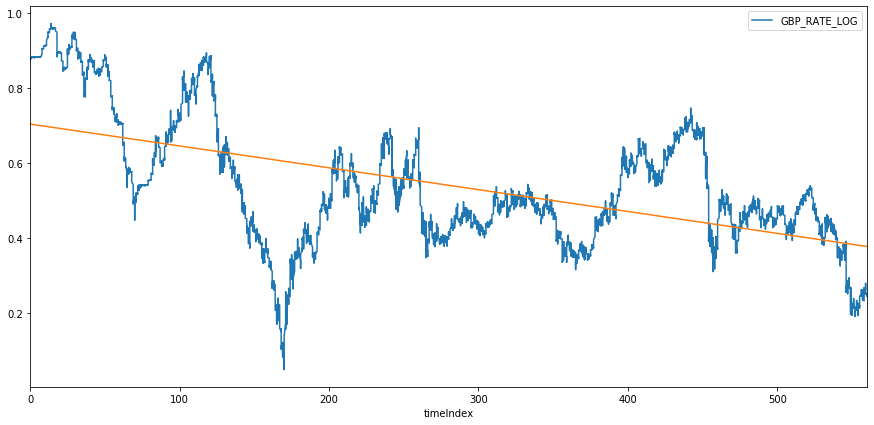

In [40]:
# Plot the prediction line
df_rate.plot(kind="line",figsize=(15, 7), x="timeIndex", y = "GBP_RATE_LOG")
plt.plot(df_rate.timeIndex,model_linear_pred, '-')

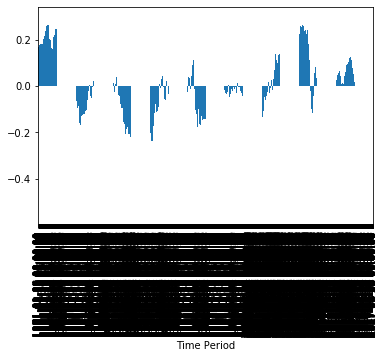

In [41]:
model_linear.resid.plot(kind = "bar")

In [42]:
# Manual Calculation
model_linear_forecast_manual = m * 146 + c
model_linear_forecast_manual

0.619540659837885

In [43]:
# Using Predict Function
model_linear_forecast_auto = model_linear.predict(exog = dict(timeIndex=146))
model_linear_forecast_auto

0    0.619541
dtype: float64

In [44]:
df_rate.head()

GBP_RATE  GBP_RATE_LOG  GBP_RATE_MEAN       date  timeIndex
Time Period                                                             
1971-01-04     2.3938      0.872882        1.71847 1971-01-04          0
1971-01-05     2.3949      0.873341        1.71847 1971-01-05          0
1971-01-06     2.3967      0.874093        1.71847 1971-01-06          0
1971-01-07     2.3963      0.873926        1.71847 1971-01-07          0
1971-01-08     2.3972      0.874301        1.71847 1971-01-08          0

In [45]:
df_rate["RateLinear"] = np.exp(model_linear_pred)

In [46]:
# Root Mean Squared Error (RMSE)
model_linear_RMSE = RMSE(df_rate.RateLinear, df_rate.GBP_RATE)
model_linear_RMSE

0.2542828784678234

In [47]:
dfResults.loc[1,"Model"] = "Linear"
dfResults.loc[1,"Forecast"] = np.exp(model_linear_forecast_manual)
dfResults.loc[1,"RMSE"] = model_linear_RMSE
dfResults.head()

Model Forecast      RMSE
0    Mean  1.71847  0.314033
1  Linear  1.85807  0.254283

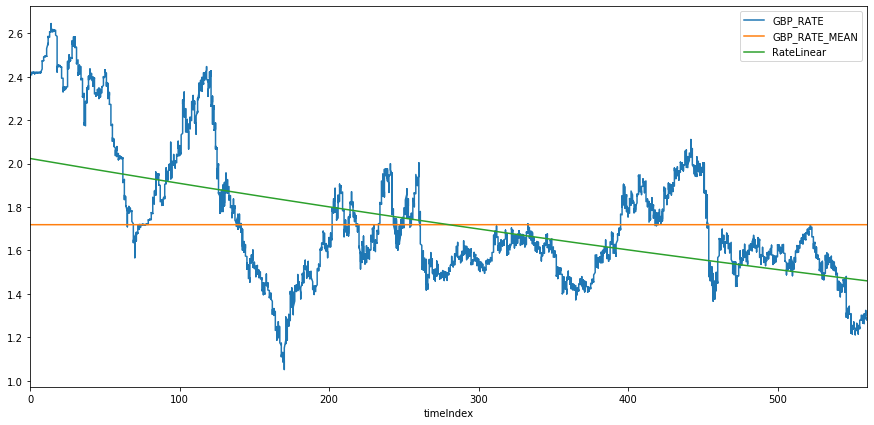

In [48]:
df_rate.plot(kind="line",figsize=(15, 7), x="timeIndex", y = ["GBP_RATE", "GBP_RATE_MEAN", "RateLinear"])

In [49]:
df_rate["RateModLogShift1"] = df_rate.GBP_RATE_LOG.shift()

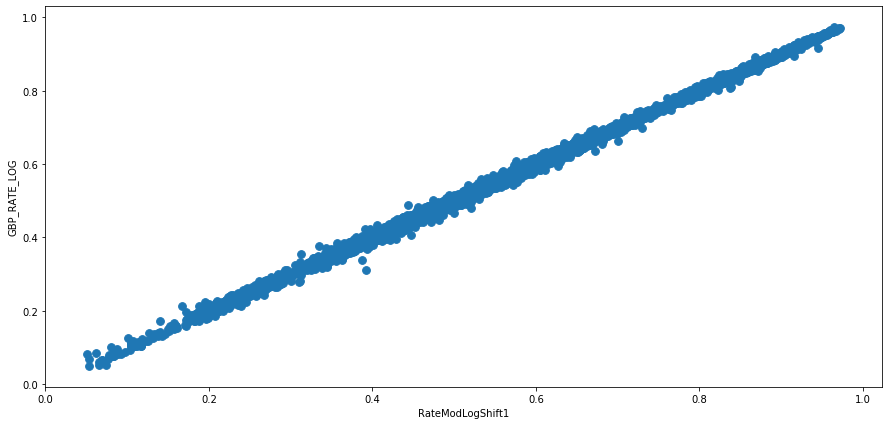

In [50]:
df_rate.plot(kind= "scatter",figsize=(15, 7), y = "GBP_RATE_LOG", x = "RateModLogShift1", s = 60)

In [51]:
# Lets plot the one-month difference curve
df_rate["RateModLogDiff"] = df_rate.GBP_RATE_LOG - df_rate.RateModLogShift1

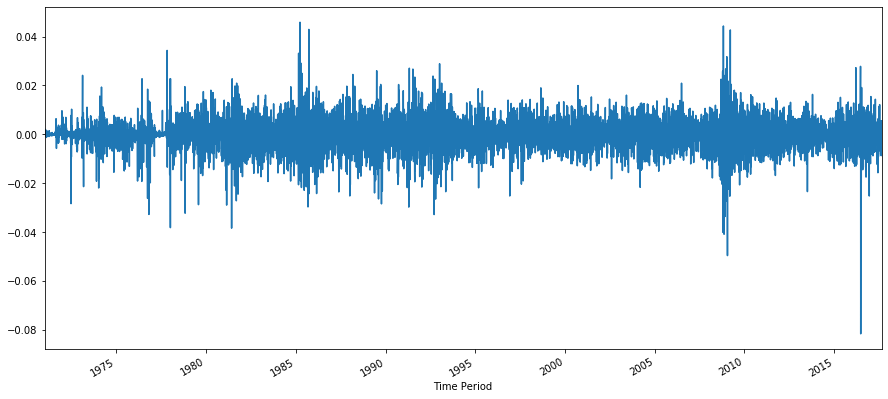

In [52]:
df_rate.RateModLogDiff.plot(figsize=(15, 7))

In [53]:
df_rate["RateRandom"] = np.exp(df_rate.RateModLogShift1)
df_rate.head()

GBP_RATE  GBP_RATE_LOG  GBP_RATE_MEAN       date  timeIndex  \
Time Period                                                                
1971-01-04     2.3938      0.872882        1.71847 1971-01-04          0   
1971-01-05     2.3949      0.873341        1.71847 1971-01-05          0   
1971-01-06     2.3967      0.874093        1.71847 1971-01-06          0   
1971-01-07     2.3963      0.873926        1.71847 1971-01-07          0   
1971-01-08     2.3972      0.874301        1.71847 1971-01-08          0   

             RateLinear  RateModLogShift1  RateModLogDiff  RateRandom  
Time Period                                                            
1971-01-04     2.022994               NaN             NaN         NaN  
1971-01-05     2.022994          0.872882        0.000459      2.3938  
1971-01-06     2.022994          0.873341        0.000751      2.3949  
1971-01-07     2.022994          0.874093       -0.000167      2.3967  
1971-01-08     2.022994          0.873926        0.000376      2.3963

In [54]:
df_rate.tail()

GBP_RATE  GBP_RATE_LOG  GBP_RATE_MEAN       date  timeIndex  \
Time Period                                                                
2017-08-21     1.2903      0.254875        1.71847 2017-08-21        560   
2017-08-22     1.2834      0.249513        1.71847 2017-08-22        560   
2017-08-23     1.2787      0.245844        1.71847 2017-08-23        560   
2017-08-24     1.2802      0.247016        1.71847 2017-08-24        560   
2017-08-25     1.2873      0.252547        1.71847 2017-08-25        560   

             RateLinear  RateModLogShift1  RateModLogDiff  RateRandom  
Time Period                                                            
2017-08-21     1.459955          0.250525        0.004350      1.2847  
2017-08-22     1.459955          0.254875       -0.005362      1.2903  
2017-08-23     1.459955          0.249513       -0.003669      1.2834  
2017-08-24     1.459955          0.245844        0.001172      1.2787  
2017-08-25     1.459955          0.247016        0.005531      1.2802

In [55]:
plt.figure(figsize=(15, 7))

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

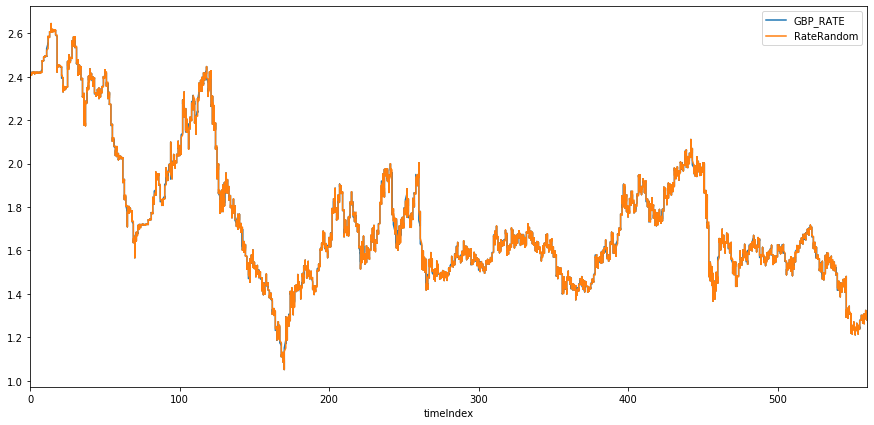

In [56]:
df_rate.plot(kind="line",figsize=(15, 7), x="timeIndex", y = ["GBP_RATE","RateRandom"])

In [57]:
# Root Mean Squared Error (RMSE)
model_random_RMSE = RMSE(df_rate.RateRandom, df_rate.GBP_RATE)
model_random_RMSE

0.010091466939352393

In [58]:
dfResults.loc[2,"Model"] = "Random"
dfResults.loc[2,"Forecast"] = np.exp(df_rate.RateModLogShift1[-1])
dfResults.loc[2,"RMSE"] = model_random_RMSE
dfResults.head()

Model Forecast       RMSE
0    Mean  1.71847   0.314033
1  Linear  1.85807   0.254283
2  Random   1.2802  0.0100915

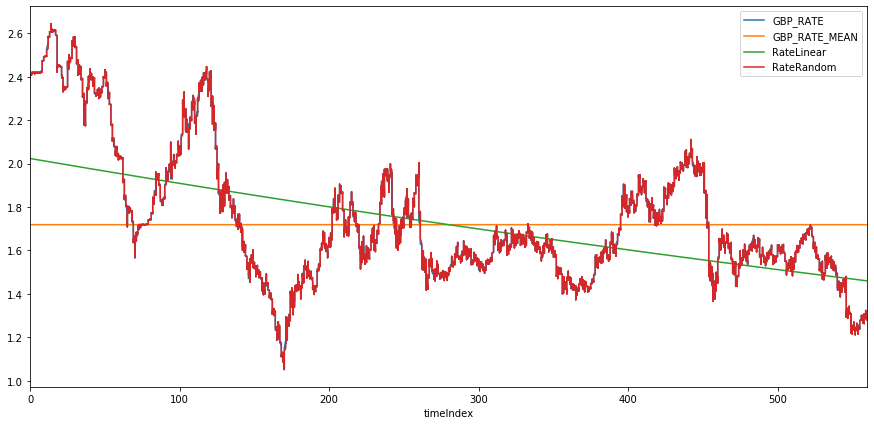

In [59]:
df_rate.plot(kind="line",figsize=(15, 7), x="timeIndex", y = ["GBP_RATE", "GBP_RATE_MEAN", "RateLinear", "RateRandom"])

In [60]:
from statsmodels.tsa.stattools import adfuller
def adf(ts):
    
    # Determing rolling statistics    
    rolmean = ts.rolling(window=12).mean()
    rolstd = ts.rolling(window=12).std()

    #Plot rolling statistics:
    ts.plot(color='blue',label='Original',figsize=(15, 7))
    rolmean.plot(color='red', label='Rolling Mean',figsize=(15, 7))
    rolstd.plot(color='black', label = 'Rolling Std',figsize=(15, 7))
    
#     plt.figure(figsize=(15,7))
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Calculate ADF factors
    adftest = adfuller(ts, autolag='AIC')
    adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','# of Lags Used',
                                              'Number of Observations Used'])
    for key,value in adftest[4].items():
        adfoutput['Critical Value (%s)'%key] = value
    return adfoutput

In [61]:
df_rate.columns

Index(['GBP_RATE', 'GBP_RATE_LOG', 'GBP_RATE_MEAN', 'date', 'timeIndex',
       'RateLinear', 'RateModLogShift1', 'RateModLogDiff', 'RateRandom'],
      dtype='object')

In [62]:
# For smoothing the values we can use 12 month Moving Averages 
df_rate['RateModLogMA12'] = df_rate.GBP_RATE_LOG.rolling(window=12).mean()

In [63]:
# df_rate = df_rate.drop('priceModLogMA12', axis=1)

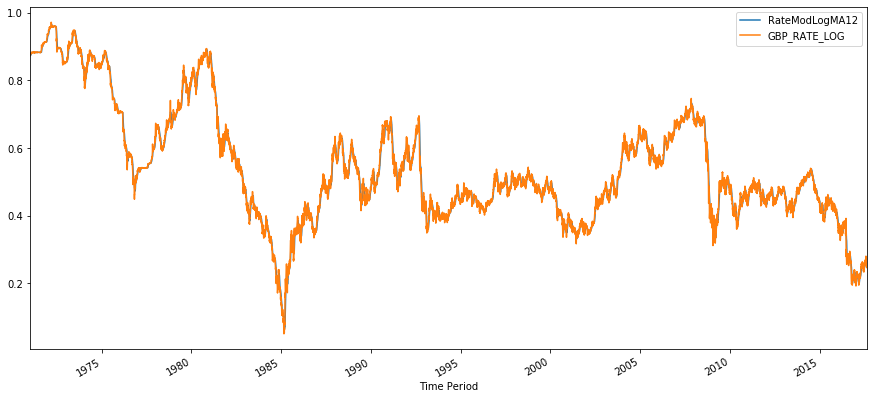

In [64]:
df_rate.plot(kind ="line",figsize=(15, 7), y=["RateModLogMA12", "GBP_RATE_LOG"])

In [65]:
df_rate["RateMA12"] = np.exp(df_rate.RateModLogMA12)
df_rate.tail()

GBP_RATE  GBP_RATE_LOG  GBP_RATE_MEAN       date  timeIndex  \
Time Period                                                                
2017-08-21     1.2903      0.254875        1.71847 2017-08-21        560   
2017-08-22     1.2834      0.249513        1.71847 2017-08-22        560   
2017-08-23     1.2787      0.245844        1.71847 2017-08-23        560   
2017-08-24     1.2802      0.247016        1.71847 2017-08-24        560   
2017-08-25     1.2873      0.252547        1.71847 2017-08-25        560   

             RateLinear  RateModLogShift1  RateModLogDiff  RateRandom  \
Time Period                                                             
2017-08-21     1.459955          0.250525        0.004350      1.2847   
2017-08-22     1.459955          0.254875       -0.005362      1.2903   
2017-08-23     1.459955          0.249513       -0.003669      1.2834   
2017-08-24     1.459955          0.245844        0.001172      1.2787   
2017-08-25     1.459955          0.247016        0.005531      1.2802   

             RateModLogMA12  RateMA12  
Time Period                            
2017-08-21         0.258003  1.294342  
2017-08-22         0.256701  1.292659  
2017-08-23         0.255190  1.290707  
2017-08-24         0.254116  1.289322  
2017-08-25         0.253318  1.288292

In [66]:
model_MA12_forecast = df_rate.GBP_RATE_LOG.tail(12).mean()

In [67]:
# Root Mean Squared Error (RMSE)
model_MA12_RMSE = RMSE(df_rate.RateMA12, df_rate.GBP_RATE)
model_MA12_RMSE

0.01973912258344672

In [68]:
dfResults.loc[3,"Model"] = "Moving Average 12"
dfResults.loc[3,"Forecast"] = np.exp(model_MA12_forecast)
dfResults.loc[3,"RMSE"] = model_MA12_RMSE
dfResults.head()

Model Forecast       RMSE
0               Mean  1.71847   0.314033
1             Linear  1.85807   0.254283
2             Random   1.2802  0.0100915
3  Moving Average 12  1.28829  0.0197391

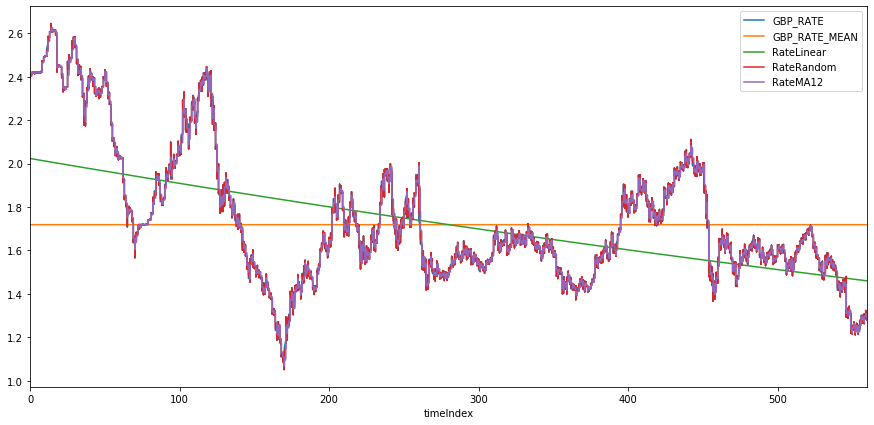

In [69]:
df_rate.plot(kind="line",figsize=(15, 7), x="timeIndex", y = ["GBP_RATE", "GBP_RATE_MEAN", "RateLinear",
                                             "RateRandom", "RateMA12"])

In [70]:
df_rate.columns

Index(['GBP_RATE', 'GBP_RATE_LOG', 'GBP_RATE_MEAN', 'date', 'timeIndex',
       'RateLinear', 'RateModLogShift1', 'RateModLogDiff', 'RateRandom',
       'RateModLogMA12', 'RateMA12'],
      dtype='object')

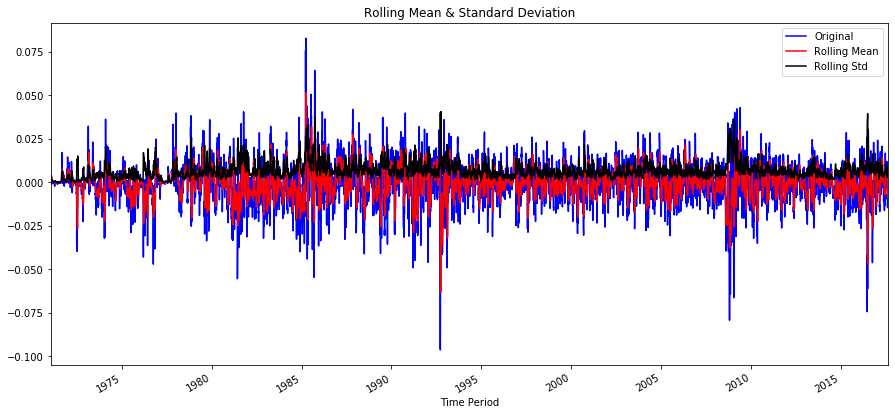

Test Statistic                -1.725898e+01
p-value                        5.957861e-30
# of Lags Used                 2.800000e+01
Number of Observations Used    1.166900e+04
Critical Value (1%)           -3.430911e+00
Critical Value (5%)           -2.861788e+00
Critical Value (10%)          -2.566902e+00
dtype: float64

In [71]:
ts = df_rate.GBP_RATE_LOG - df_rate.RateModLogMA12
ts.dropna(inplace=True)
adf(ts)

In [72]:
# Import statsmodel
import statsmodels.api as sm
import statsmodels.formula.api as smf

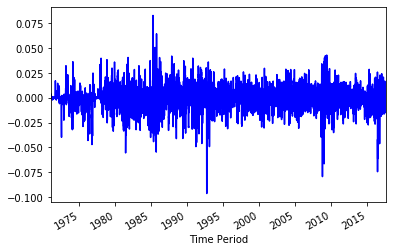

In [73]:
ts.plot( color='blue',label='Original')

In [74]:
df_rate.columns

Index(['GBP_RATE', 'GBP_RATE_LOG', 'GBP_RATE_MEAN', 'date', 'timeIndex',
       'RateLinear', 'RateModLogShift1', 'RateModLogDiff', 'RateRandom',
       'RateModLogMA12', 'RateMA12'],
      dtype='object')

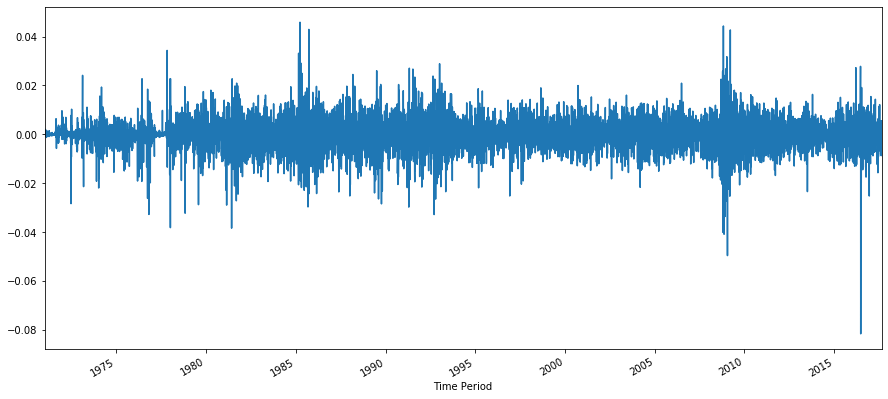

In [75]:
df_rate.RateModLogDiff.plot(figsize=(15, 7))

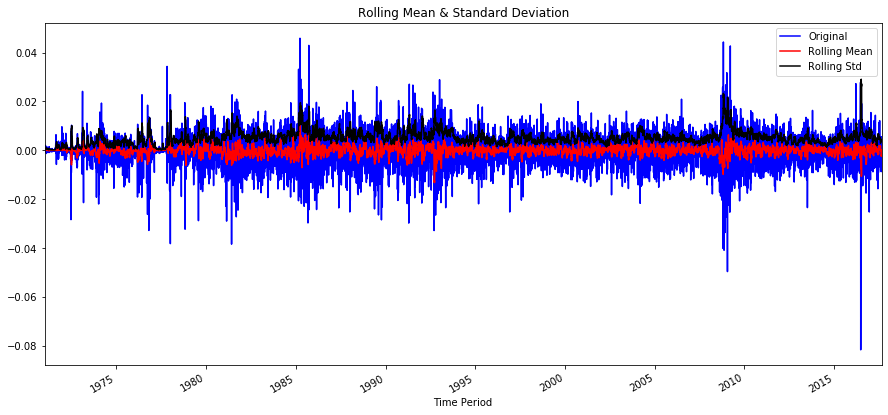

Test Statistic                   -18.921187
p-value                            0.000000
# of Lags Used                    27.000000
Number of Observations Used    11680.000000
Critical Value (1%)               -3.430910
Critical Value (5%)               -2.861787
Critical Value (10%)              -2.566902
dtype: float64

In [76]:
# Test remaining part for Stationary
ts = df_rate.RateModLogDiff
ts.dropna(inplace = True)
adf(ts)

### 2.ARIMA MODEL

In [77]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [78]:
ts = df_rate.GBP_RATE_LOG
ts_diff = df_rate.RateModLogDiff
ts_diff.dropna(inplace = True)

In [79]:
lag_acf = acf(ts_diff, nlags=20)

In [80]:
lag_acf

array([ 1.00000000e+00,  4.62980340e-02,  4.84438533e-04, -1.73824501e-02,
        4.15110285e-03,  1.93889202e-03,  1.22617950e-02, -5.25691482e-03,
       -2.39671383e-03,  2.65466469e-02, -3.01546135e-02, -8.08961568e-03,
       -3.03042622e-03,  6.62147340e-03,  1.22935235e-02,  2.44478011e-02,
        9.07668563e-03, -8.27737357e-03,  3.36313546e-03,  1.37569109e-02,
        2.23385637e-02])

In [81]:
ACF = pd.Series(lag_acf)

In [82]:
ACF

0     1.000000
1     0.046298
2     0.000484
3    -0.017382
4     0.004151
5     0.001939
6     0.012262
7    -0.005257
8    -0.002397
9     0.026547
10   -0.030155
11   -0.008090
12   -0.003030
13    0.006621
14    0.012294
15    0.024448
16    0.009077
17   -0.008277
18    0.003363
19    0.013757
20    0.022339
dtype: float64

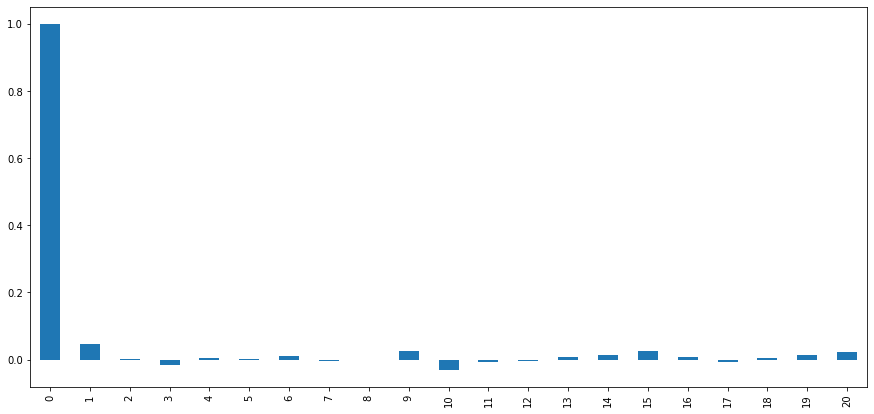

In [83]:
ACF.plot(kind = "bar",figsize=(15, 7))

In [84]:
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

In [85]:
PACF = pd.Series(lag_pacf)

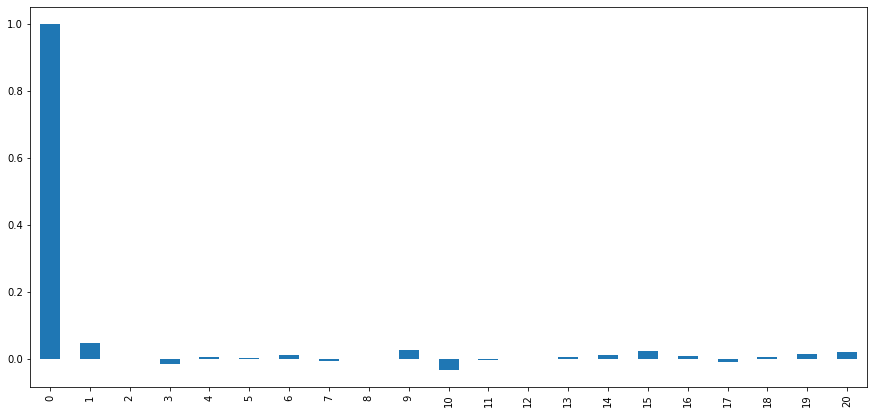

In [86]:
PACF.plot(kind = "bar",figsize=(15, 7))

In [87]:
from statsmodels.tsa.arima_model import ARIMA

In [88]:
ts_diff.head()

Time Period
1971-01-05    0.000459
1971-01-06    0.000751
1971-01-07   -0.000167
1971-01-08    0.000376
1971-01-11    0.000834
Name: RateModLogDiff, dtype: float64

In [89]:
# Running the ARIMA Model(1,0,1)
model_AR1MA = ARIMA(ts_diff, order=(1,0,1))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [90]:
results_ARIMA = model_AR1MA.fit(disp = -1)

In [91]:
results_ARIMA.fittedvalues.head()

Time Period
1971-01-05   -0.000053
1971-01-06   -0.000029
1971-01-07   -0.000016
1971-01-08   -0.000059
1971-01-11   -0.000033
dtype: float64

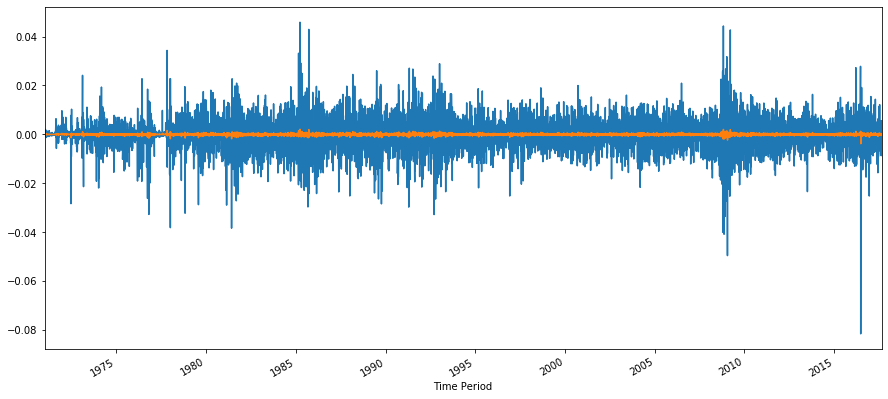

In [92]:
ts_diff.plot()
results_ARIMA.fittedvalues.plot(figsize=(15, 7))

In [93]:
ts_diff.sum()

-0.6203350597736814

In [94]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.tail()

Time Period
2017-08-21   -0.000200
2017-08-22    0.000154
2017-08-23   -0.000303
2017-08-24   -0.000215
2017-08-25    0.000007
dtype: float64

In [95]:
predictions_ARIMA_diff.sum()

-0.6203663424840011

In [96]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.tail()

Time Period
2017-08-21   -0.620009
2017-08-22   -0.619855
2017-08-23   -0.620158
2017-08-24   -0.620373
2017-08-25   -0.620366
dtype: float64

In [97]:
ts.ix[0]

0.8728820614571331

In [98]:
predictions_ARIMA_log = pd.Series(ts.ix[0], index=ts.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.tail()

Time Period
2017-08-21    0.252873
2017-08-22    0.253027
2017-08-23    0.252724
2017-08-24    0.252509
2017-08-25    0.252516
dtype: float64

In [99]:
df_rate['RateARIMA'] = np.exp(predictions_ARIMA_log)

In [100]:
df_rate.columns

Index(['GBP_RATE', 'GBP_RATE_LOG', 'GBP_RATE_MEAN', 'date', 'timeIndex',
       'RateLinear', 'RateModLogShift1', 'RateModLogDiff', 'RateRandom',
       'RateModLogMA12', 'RateMA12', 'RateARIMA'],
      dtype='object')

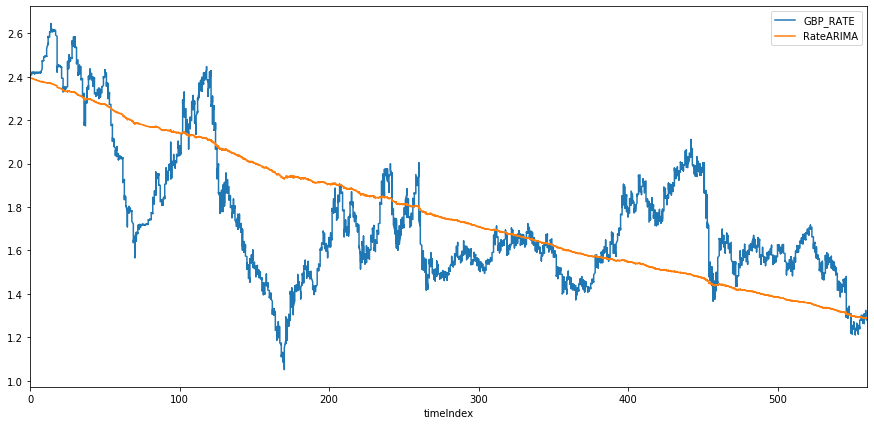

In [101]:
df_rate.plot(kind="line", x="timeIndex", y = ["GBP_RATE", "RateARIMA"],figsize=(15, 7))

### 3.SARIMA MODEL

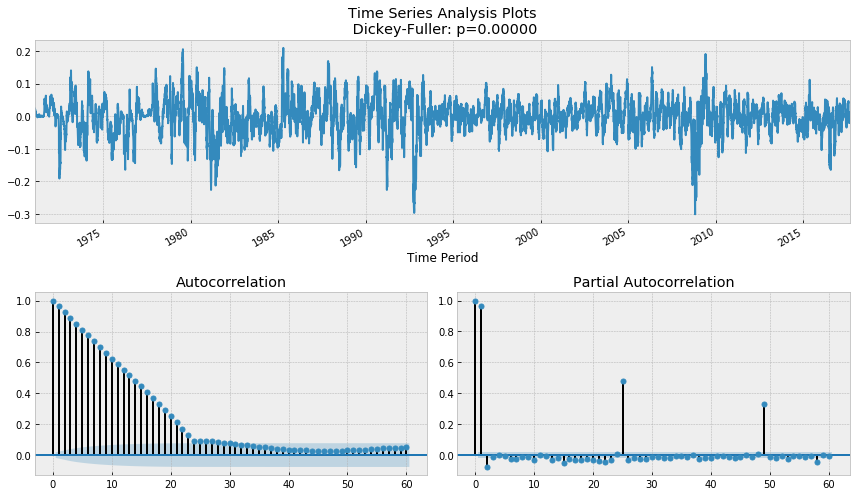

In [102]:
tsplot(ads_diff[24+1:], lags=60)

In [103]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [104]:
df_rate_sarima = df.loc[(df['RXI$US_N.B.UK'] != 'ND'), ['RXI$US_N.B.UK']]

In [105]:
df_rate_sarima.rename(columns={'RXI$US_N.B.UK':'GBP_RATE'}, inplace=True)

In [106]:
df_rate_sarima.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11709 entries, 1971-01-04 to 2017-08-25
Data columns (total 1 columns):
GBP_RATE    11709 non-null object
dtypes: object(1)
memory usage: 183.0+ KB


In [107]:
# df_rate_sarima['timestamp'] = pd.to_datetime(df_rate_sarima.index,unit='ms').date

In [108]:
df_rate_sarima['GBP_RATE'] = pd.to_numeric(df_rate_sarima['GBP_RATE'])

In [109]:
df_rate_sarima[df_rate_sarima.GBP_RATE=='NaN'].count()

GBP_RATE    0
dtype: int64

In [110]:
df_rate_sarima.index[0]

Timestamp('1971-01-04 00:00:00')

In [111]:
df_rate_sarima.shape

(11709, 1)

In [112]:
df_rate_sarima.index = pd.to_datetime(df_rate_sarima.index , format = '%d/%m/%Y %H.%M.%S')

In [113]:
df_rate_sarima.index = pd.to_datetime(df_rate_sarima.index)

In [114]:
df_rate_sarima.index = pd.to_datetime(df_rate_sarima.index, format = '%m/%d/%Y')

In [115]:
print(type(df_rate_sarima.index[1]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [116]:
df_rate_sarima.isnull().sum()

GBP_RATE    0
dtype: int64

In [117]:
try:
    pd.to_datetime(df_rate_sarima.index, format='%y-%d-%m', errors='raise')
    # do something
    print('aaa')
except ValueError:
    print('bbb')

aaa


In [118]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(df_rate_sarima.GBP_RATE, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    print(results)
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [119]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. foreca

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. foreca


[[(2, 2, 0, 0), -66361.28609786594], [(2, 2, 0, 1), -74117.68037483671], [(2, 2, 1, 0), -66361.28609786594], [(2, 2, 1, 1), -74117.68037483671], [(2, 3, 0, 0), -66366.10474342105], [(2, 3, 0, 1), -73934.1502079961], [(2, 3, 1, 0), -66366.10474342105], [(2, 3, 1, 1), -73934.1502079961], [(2, 4, 0, 0), -66358.6106722194], [(2, 4, 0, 1), -74115.81615222021], [(2, 4, 1, 0), -66358.6106722194], [(2, 4, 1, 1), -74115.81615222021], [(3, 2, 0, 0), -66465.11807393278], [(3, 2, 0, 1), -74023.65757450185], [(3, 2, 1, 0), -66465.11807393278], [(3, 2, 1, 1), -74023.65757450185], [(3, 3, 0, 0), -66355.94376044901], [(3, 3, 0, 1), -74000.87098464133], [(3, 3, 1, 0), -66355.94376044901], [(3, 3, 1, 1), -74000.87098464133], [(3, 4, 0, 0), -66355.10568250898], [(3, 4, 0, 1), -74086.94115554054], [(3, 4, 1, 0), -66355.10568250898], [(3, 4, 1, 1), -74086.94115554054], [(4, 2, 0, 0), -66359.10890751072], [(4, 2, 0, 1), -74064.20212774724], [(4, 2, 1, 0), -66359.10890751072], [(4, 2, 1, 1), -74064.20212774

In [61]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [62]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 

    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    print(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
#     error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
#     plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    print(forecast.shape)
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

In [166]:
df_rate = df_rate.tz_localize('utc')

In [174]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df_rate.GBP_RATE, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                           GBP_RATE   No. Observations:                11709
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 24)   Log Likelihood               37064.708
Date:                            Mon, 07 Oct 2019   AIC                         -74117.417
Time:                                    16:37:06   BIC                         -74073.221
Sample:                                         0   HQIC                        -74102.572
                                          - 11709                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5106      0.355      1.439      0.150      -0.185       1.206
ar.L2         -0.2479      0.145   

In [123]:
result_table.head()

parameters           aic
0  (2, 2, 0, 1) -74117.680375
1  (2, 2, 1, 1) -74117.680375
2  (2, 4, 0, 1) -74115.816152
3  (2, 4, 1, 1) -74115.816152
4  (3, 4, 1, 1) -74086.941156

In [175]:
result_table.shape

(36, 2)

In [124]:
# df_rate = df_rate.drop('timestamp', axis=1)

In [125]:
# df_rate.index= pd.to_datetime(df_rate.index,unit='ms').date

In [126]:
# ser_sarima = abc.groupby('timestamp').mean()['GBP_RATE']

In [127]:
# type(ser_sarima[0])

In [128]:
# abc = abc.reset_index(drop=True)

In [131]:
df_rate.shape

(11709, 12)

In [178]:
df_rate_1 = df_rate['GBP_RATE']

In [179]:
df_rate_1.head()

Time Period
1971-01-04 00:00:00+00:00    2.3938
1971-01-05 00:00:00+00:00    2.3949
1971-01-06 00:00:00+00:00    2.3967
1971-01-07 00:00:00+00:00    2.3963
1971-01-08 00:00:00+00:00    2.3972
Name: GBP_RATE, dtype: float64

In [158]:
# df_rate_1.index = df_rate_1['Time Period']
# df_rate_1 = df_rate_1.drop('Time Period', axis=1)

In [164]:
# ab = best_model.fittedvalues
# len(ab)

11709

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1971-01-04 00:00:00+00:00         NaN
1971-01-05 00:00:00+00:00         NaN
1971-01-06 00:00:00+00:00         NaN
1971-01-07 00:00:00+00:00         NaN
1971-01-08 00:00:00+00:00         NaN
1971-01-11 00:00:00+00:00         NaN
1971-01-12 00:00:00+00:00         NaN
1971-01-13 00:00:00+00:00         NaN
1971-01-14 00:00:00+00:00         NaN
1971-01-15 00:00:00+00:00         NaN
1971-01-18 00:00:00+00:00         NaN
1971-01-19 00:00:00+00:00         NaN
1971-01-20 00:00:00+00:00         NaN
1971-01-21 00:00:00+00:00         NaN
1971-01-22 00:00:00+00:00         NaN
1971-01-25 00:00:00+00:00         NaN
1971-01-26 00:00:00+00:00         NaN
1971-01-27 00:00:00+00:00         NaN
1971-01-28 00:00:00+00:00         NaN
1971-01-29 00:00:00+00:00         NaN
1971-02-01 00:00:00+00:00         NaN
1971-02-02 00:00:00+00:00         NaN
1971-02-03 00:00:00+00:00         NaN
1971-02-04 00:00:00+00:00         NaN
1971-02-05 00:00:00+00:00         NaN
1971-02-08 00:00:00+00:00    2.415800
1971-02-09 0

ConversionError: Failed to convert value(s) to axis units: array([Timestamp('1971-01-04 00:00:00+0000', tz='UTC'),
       Timestamp('1971-01-05 00:00:00+0000', tz='UTC'),
       Timestamp('1971-01-06 00:00:00+0000', tz='UTC'), ..., 11768, 11769,
       11770], dtype=object)

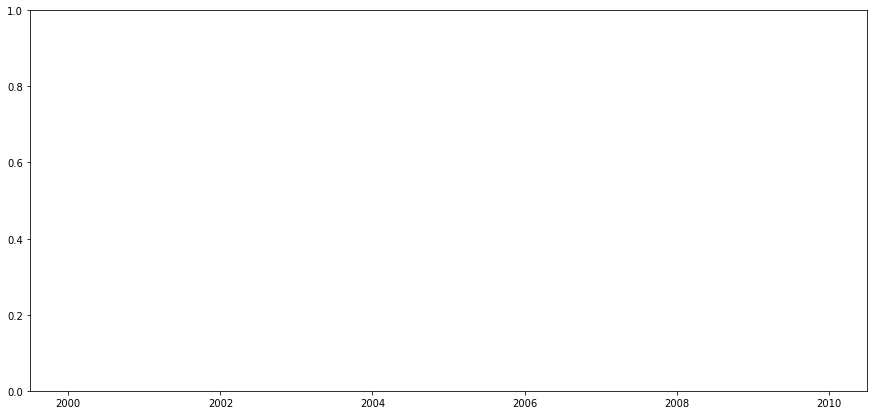

In [204]:
plotSARIMA(df_rate['GBP_RATE'], best_model, 60)

### 4.LSTM MODEL

In [205]:
df_rate_lstm = df.loc[(df['RXI$US_N.B.UK'] != 'ND'), ['RXI$US_N.B.UK']]

In [206]:
df_rate_lstm.rename(columns={'RXI$US_N.B.UK':'GBP_RATE'}, inplace=True)

In [207]:
df_rate_lstm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11709 entries, 1971-01-04 to 2017-08-25
Data columns (total 1 columns):
GBP_RATE    11709 non-null object
dtypes: object(1)
memory usage: 183.0+ KB


In [208]:
df_rate_lstm['timestamp'] = pd.to_datetime(df_rate_lstm.index,unit='ms').date

In [209]:
df_rate_lstm['GBP_RATE'] = pd.to_numeric(df_rate_lstm['GBP_RATE'])

In [210]:
df_rate_lstm.head()

GBP_RATE   timestamp
Time Period                      
1971-01-04     2.3938  1971-01-04
1971-01-05     2.3949  1971-01-05
1971-01-06     2.3967  1971-01-06
1971-01-07     2.3963  1971-01-07
1971-01-08     2.3972  1971-01-08

In [211]:
ser = df_rate_lstm

In [231]:
def rate_matrix_creator(data, seq_len=30):
    '''
    It converts the series into a nested list where every item of the list contains historic rates of 30 days
    '''
    rate_matrix = []
    for index in range(len(data)-seq_len+1):
        rate_matrix.append(data[index:index+seq_len])
    return rate_matrix

def normalize_windows(window_data):
    '''
    It normalizes each value to reflect the percentage changes from starting point
    '''
    normalised_data = []
    for window in window_data:
        if float(window[0]) == 0.0:
            window_0 = 0.000000001
        else:
            window_0 = window[0]    
        #normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_window = [0.0 if float(p) == 0.0 else ((float(p) / window_0) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def train_test_split_(rate_matrix, train_size=0.9, shuffle=False, return_row=True):
    '''
    It makes a custom train test split where the last part is kept as the training set.
    '''
    rate_matrix = np.array(rate_matrix)
    #print(rate_matrix.shape)
    row = int(round(train_size * len(rate_matrix)))
    train = rate_matrix[:row, :]
    if shuffle==True:
        np.random.shuffle(train)
    X_train, y_train = train[:row,:-1], train[:row,-1]
    X_test, y_test = rate_matrix[row:,:-1], rate_matrix[row:,-1]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    if return_row:
        return row, X_train, y_train, X_test, y_test
    else:
        X_train, y_train, X_test, y_test

In [213]:
ser = df_rate_lstm.groupby('timestamp').mean()['GBP_RATE']

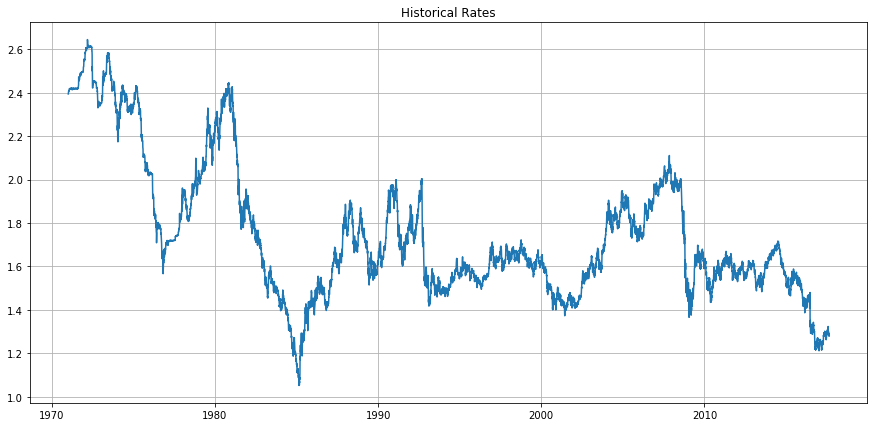

In [214]:
plt.figure(figsize=(15, 7))
plt.plot(ser)
plt.title('Historical Rates')
plt.grid(True)
plt.show()

In [232]:
rate_matrix_ser = rate_matrix_creator(ser)

In [234]:
#price_matrix = rate_matrix_creator(ser) # Creating a matrix using the dataframe
rate_matrix = normalize_windows(rate_matrix_ser) # Normalizing its values to fit to RNN
row, X_train, y_train, X_test, y_test = train_test_split_(rate_matrix) # Applying train-test splitting, also returning the splitting-point

In [235]:
X_test_plotly = X_test.copy()
y_test_plotly = y_test.copy()
ser_plotly = ser.copy()

In [238]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
import time
# LSTM Model parameters, I chose
batch_size = 2            # Batch size (you may try different values)
epochs = 10               # Epoch (you may try different values)
seq_len = 30              # 30 sequence data (Representing the last 30 days)
loss='mean_squared_error' # Since the metric is MSE/RMSE
optimizer = 'rmsprop'     # Recommended optimizer for RNN
activation = 'tanh'     
input_shape=(None,1)      # Input dimension
output_dim = 30           # Output dimension

In [239]:
model = Sequential()
model.add(LSTM(units=output_dim, return_sequences=True, input_shape=input_shape))
model.add(Dense(units=32,activation=activation))
model.add(LSTM(units=output_dim, return_sequences=False))
model.add(Dense(units=1,activation=activation))
model.compile(optimizer=optimizer,loss=loss)

In [240]:
start_time = time.time()
model.fit(x=X_train,
          y=y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.05)
end_time = time.time()
processing_time = end_time - start_time

Train on 9986 samples, validate on 526 samples
Epoch 1/10


2830/9986 [=======>......................] - ETA: 36:05 - loss: 4.1368e- - ETA: 6:49 - loss: 0.0025     - ETA: 4:07 - loss: 0.001 - ETA: 3:07 - loss: 0.001 - ETA: 2:35 - loss: 0.001 - ETA: 2:15 - loss: 9.7479e-0 - ETA: 2:02 - loss: 8.6887e-0 - ETA: 1:53 - loss: 7.7662e-0 - ETA: 1:46 - loss: 7.3993e-0 - ETA: 1:41 - loss: 6.7987e-0 - ETA: 1:36 - loss: 6.6084e-0 - ETA: 1:33 - loss: 6.1582e-0 - ETA: 1:30 - loss: 5.9903e-0 - ETA: 1:27 - loss: 5.7572e-0 - ETA: 1:25 - loss: 5.7789e-0 - ETA: 1:24 - loss: 5.6029e-0 - ETA: 1:22 - loss: 5.8699e-0 - ETA: 1:20 - loss: 5.5546e-0 - ETA: 1:18 - loss: 5.2792e-0 - ETA: 1:17 - loss: 5.4249e-0 - ETA: 1:15 - loss: 5.2745e-0 - ETA: 1:14 - loss: 5.0795e-0 - ETA: 1:13 - loss: 5.2184e-0 - ETA: 1:12 - loss: 5.0538e-0 - ETA: 1:11 - loss: 4.9260e-0 - ETA: 1:10 - loss: 4.7819e-0 - ETA: 1:10 - loss: 4.7134e-0 - ETA: 1:09 - loss: 4.5660e-0 - ETA: 1:08 - loss: 4.4357e-0 - ETA: 1:08 - loss: 4.3643e-0 - ETA: 1:07 - loss: 4.2802e-0 - ETA: 1:06 - loss: 4.1769e-0 - ETA: 1

9986/9986 [==============================] - ETA: 6s - loss: 9.2510e-0 - ETA: 6s - loss: 9.2549e-0 - ETA: 6s - loss: 9.2477e-0 - ETA: 6s - loss: 9.2398e-0 - ETA: 6s - loss: 9.2386e-0 - ETA: 6s - loss: 9.2351e-0 - ETA: 6s - loss: 9.2541e-0 - ETA: 6s - loss: 9.2608e-0 - ETA: 6s - loss: 9.2524e-0 - ETA: 6s - loss: 9.2480e-0 - ETA: 6s - loss: 9.2426e-0 - ETA: 6s - loss: 9.2474e-0 - ETA: 6s - loss: 9.2436e-0 - ETA: 6s - loss: 9.2417e-0 - ETA: 6s - loss: 9.2326e-0 - ETA: 6s - loss: 9.2261e-0 - ETA: 6s - loss: 9.2180e-0 - ETA: 5s - loss: 9.2090e-0 - ETA: 5s - loss: 9.2043e-0 - ETA: 5s - loss: 9.1963e-0 - ETA: 5s - loss: 9.1873e-0 - ETA: 5s - loss: 9.1822e-0 - ETA: 5s - loss: 9.1777e-0 - ETA: 5s - loss: 9.1696e-0 - ETA: 5s - loss: 9.1654e-0 - ETA: 5s - loss: 9.1598e-0 - ETA: 5s - loss: 9.1521e-0 - ETA: 5s - loss: 9.1452e-0 - ETA: 5s - loss: 9.1367e-0 - ETA: 5s - loss: 9.1342e-0 - ETA: 5s - loss: 9.1409e-0 - ETA: 5s - loss: 9.1350e-0 - ETA: 5s - loss: 9.1303e-0 - ETA: 5s - loss: 9.1273e-0 - ETA

2982/9986 [=======>......................] - ETA: 1:04 - loss: 3.5467e-0 - ETA: 53s - loss: 7.4851e-0 - ETA: 53s - loss: 5.1624e- - ETA: 52s - loss: 5.3294e- - ETA: 52s - loss: 7.5241e- - ETA: 51s - loss: 6.4200e- - ETA: 51s - loss: 5.6235e- - ETA: 51s - loss: 5.8847e- - ETA: 51s - loss: 5.5527e- - ETA: 51s - loss: 6.7706e- - ETA: 51s - loss: 6.2562e- - ETA: 51s - loss: 5.9844e- - ETA: 51s - loss: 5.8459e- - ETA: 51s - loss: 5.6955e- - ETA: 50s - loss: 5.7003e- - ETA: 50s - loss: 5.5925e- - ETA: 50s - loss: 5.4869e- - ETA: 50s - loss: 5.4716e- - ETA: 50s - loss: 6.2060e- - ETA: 50s - loss: 6.2077e- - ETA: 50s - loss: 6.1679e- - ETA: 50s - loss: 5.9816e- - ETA: 50s - loss: 5.7541e- - ETA: 50s - loss: 5.8961e- - ETA: 50s - loss: 5.8045e- - ETA: 50s - loss: 5.7381e- - ETA: 50s - loss: 5.6931e- - ETA: 50s - loss: 5.7646e- - ETA: 50s - loss: 5.6893e- - ETA: 50s - loss: 5.5535e- - ETA: 50s - loss: 5.5018e- - ETA: 50s - loss: 5.5258e- - ETA: 49s - loss: 5.4529e- - ETA: 49s - loss: 5.4880e- - 

9986/9986 [==============================] - ETA: 5s - loss: 5.3685e-0 - ETA: 5s - loss: 5.3773e-0 - ETA: 5s - loss: 5.3752e-0 - ETA: 4s - loss: 5.3755e-0 - ETA: 4s - loss: 5.3748e-0 - ETA: 4s - loss: 5.3755e-0 - ETA: 4s - loss: 5.3715e-0 - ETA: 4s - loss: 5.3749e-0 - ETA: 4s - loss: 5.3716e-0 - ETA: 4s - loss: 5.3751e-0 - ETA: 4s - loss: 5.3738e-0 - ETA: 4s - loss: 5.3711e-0 - ETA: 4s - loss: 5.3713e-0 - ETA: 4s - loss: 5.3691e-0 - ETA: 4s - loss: 5.3666e-0 - ETA: 4s - loss: 5.3619e-0 - ETA: 4s - loss: 5.3585e-0 - ETA: 4s - loss: 5.3572e-0 - ETA: 4s - loss: 5.3585e-0 - ETA: 4s - loss: 5.3580e-0 - ETA: 4s - loss: 5.3568e-0 - ETA: 4s - loss: 5.3551e-0 - ETA: 3s - loss: 5.3528e-0 - ETA: 3s - loss: 5.3678e-0 - ETA: 3s - loss: 5.3672e-0 - ETA: 3s - loss: 5.3628e-0 - ETA: 3s - loss: 5.3589e-0 - ETA: 3s - loss: 5.3581e-0 - ETA: 3s - loss: 5.3569e-0 - ETA: 3s - loss: 5.3540e-0 - ETA: 3s - loss: 5.3531e-0 - ETA: 3s - loss: 5.3530e-0 - ETA: 3s - loss: 5.3504e-0 - ETA: 3s - loss: 5.3489e-0 - ETA

2950/9986 [=======>......................] - ETA: 59s - loss: 3.7670e- - ETA: 50s - loss: 2.2494e- - ETA: 51s - loss: 3.4723e- - ETA: 51s - loss: 3.1698e- - ETA: 52s - loss: 3.1255e- - ETA: 53s - loss: 3.8337e- - ETA: 53s - loss: 3.8856e- - ETA: 54s - loss: 3.7006e- - ETA: 55s - loss: 4.0753e- - ETA: 55s - loss: 6.3706e- - ETA: 55s - loss: 6.0255e- - ETA: 55s - loss: 5.6930e- - ETA: 56s - loss: 5.4724e- - ETA: 56s - loss: 5.4092e- - ETA: 56s - loss: 5.4400e- - ETA: 56s - loss: 5.5409e- - ETA: 57s - loss: 5.8391e- - ETA: 57s - loss: 5.6956e- - ETA: 56s - loss: 5.4913e- - ETA: 57s - loss: 5.9972e- - ETA: 57s - loss: 6.0078e- - ETA: 57s - loss: 6.0712e- - ETA: 56s - loss: 5.8951e- - ETA: 56s - loss: 5.6747e- - ETA: 56s - loss: 5.5383e- - ETA: 56s - loss: 5.6400e- - ETA: 55s - loss: 5.7256e- - ETA: 55s - loss: 5.7332e- - ETA: 55s - loss: 5.5568e- - ETA: 55s - loss: 5.4147e- - ETA: 55s - loss: 5.3477e- - ETA: 54s - loss: 5.3513e- - ETA: 54s - loss: 5.5741e- - ETA: 55s - loss: 5.5496e- - ETA

9986/9986 [==============================] - ETA: 5s - loss: 4.9156e-0 - ETA: 5s - loss: 4.9153e-0 - ETA: 5s - loss: 4.9213e-0 - ETA: 5s - loss: 4.9222e-0 - ETA: 5s - loss: 4.9248e-0 - ETA: 5s - loss: 4.9247e-0 - ETA: 5s - loss: 4.9305e-0 - ETA: 5s - loss: 4.9275e-0 - ETA: 5s - loss: 4.9310e-0 - ETA: 5s - loss: 4.9248e-0 - ETA: 5s - loss: 4.9259e-0 - ETA: 5s - loss: 4.9325e-0 - ETA: 5s - loss: 4.9320e-0 - ETA: 5s - loss: 4.9300e-0 - ETA: 4s - loss: 4.9367e-0 - ETA: 4s - loss: 4.9555e-0 - ETA: 4s - loss: 4.9562e-0 - ETA: 4s - loss: 4.9598e-0 - ETA: 4s - loss: 4.9590e-0 - ETA: 4s - loss: 4.9552e-0 - ETA: 4s - loss: 4.9689e-0 - ETA: 4s - loss: 4.9666e-0 - ETA: 4s - loss: 4.9639e-0 - ETA: 4s - loss: 4.9848e-0 - ETA: 4s - loss: 4.9938e-0 - ETA: 4s - loss: 4.9932e-0 - ETA: 4s - loss: 4.9891e-0 - ETA: 4s - loss: 4.9898e-0 - ETA: 4s - loss: 4.9854e-0 - ETA: 4s - loss: 4.9893e-0 - ETA: 4s - loss: 4.9896e-0 - ETA: 4s - loss: 4.9855e-0 - ETA: 4s - loss: 4.9874e-0 - ETA: 3s - loss: 4.9858e-0 - ETA

2972/9986 [=======>......................] - ETA: 59s - loss: 2.6489e- - ETA: 49s - loss: 3.4276e- - ETA: 50s - loss: 2.4724e- - ETA: 50s - loss: 2.6674e- - ETA: 50s - loss: 2.8047e- - ETA: 50s - loss: 2.9446e- - ETA: 51s - loss: 2.7401e- - ETA: 51s - loss: 2.9766e- - ETA: 51s - loss: 3.0180e- - ETA: 51s - loss: 3.5005e- - ETA: 51s - loss: 3.3737e- - ETA: 51s - loss: 3.3929e- - ETA: 51s - loss: 3.4172e- - ETA: 51s - loss: 3.4223e- - ETA: 50s - loss: 3.4286e- - ETA: 51s - loss: 3.6599e- - ETA: 50s - loss: 3.6684e- - ETA: 51s - loss: 3.6153e- - ETA: 51s - loss: 3.5460e- - ETA: 50s - loss: 3.4551e- - ETA: 50s - loss: 3.4112e- - ETA: 50s - loss: 3.4422e- - ETA: 50s - loss: 3.5042e- - ETA: 50s - loss: 3.5574e- - ETA: 50s - loss: 3.6312e- - ETA: 50s - loss: 3.6407e- - ETA: 50s - loss: 3.6446e- - ETA: 50s - loss: 3.6285e- - ETA: 50s - loss: 3.7957e- - ETA: 50s - loss: 3.8286e- - ETA: 50s - loss: 3.8986e- - ETA: 50s - loss: 3.8738e- - ETA: 50s - loss: 3.8090e- - ETA: 50s - loss: 4.0755e- - ETA

9986/9986 [==============================] - ETA: 5s - loss: 4.8241e-0 - ETA: 5s - loss: 4.8329e-0 - ETA: 5s - loss: 4.8322e-0 - ETA: 5s - loss: 4.8291e-0 - ETA: 5s - loss: 4.8268e-0 - ETA: 5s - loss: 4.8256e-0 - ETA: 5s - loss: 4.8244e-0 - ETA: 5s - loss: 4.8264e-0 - ETA: 5s - loss: 4.8260e-0 - ETA: 5s - loss: 4.8357e-0 - ETA: 5s - loss: 4.8326e-0 - ETA: 5s - loss: 4.8304e-0 - ETA: 4s - loss: 4.8288e-0 - ETA: 4s - loss: 4.8311e-0 - ETA: 4s - loss: 4.8355e-0 - ETA: 4s - loss: 4.8332e-0 - ETA: 4s - loss: 4.8339e-0 - ETA: 4s - loss: 4.8342e-0 - ETA: 4s - loss: 4.8306e-0 - ETA: 4s - loss: 4.8283e-0 - ETA: 4s - loss: 4.8492e-0 - ETA: 4s - loss: 4.8518e-0 - ETA: 4s - loss: 4.8489e-0 - ETA: 4s - loss: 4.8472e-0 - ETA: 4s - loss: 4.8443e-0 - ETA: 4s - loss: 4.8447e-0 - ETA: 4s - loss: 4.8409e-0 - ETA: 4s - loss: 4.8412e-0 - ETA: 4s - loss: 4.8381e-0 - ETA: 4s - loss: 4.8347e-0 - ETA: 4s - loss: 4.8322e-0 - ETA: 3s - loss: 4.8322e-0 - ETA: 3s - loss: 4.8312e-0 - ETA: 3s - loss: 4.8259e-0 - ETA

2948/9986 [=======>......................] - ETA: 59s - loss: 1.4054e- - ETA: 53s - loss: 2.1300e- - ETA: 52s - loss: 1.4008e- - ETA: 52s - loss: 1.0473e- - ETA: 52s - loss: 1.1722e- - ETA: 51s - loss: 9.6878e- - ETA: 51s - loss: 8.7506e- - ETA: 51s - loss: 8.4400e- - ETA: 51s - loss: 8.0867e- - ETA: 51s - loss: 8.5956e- - ETA: 51s - loss: 8.1454e- - ETA: 51s - loss: 7.7749e- - ETA: 51s - loss: 7.2260e- - ETA: 51s - loss: 7.0351e- - ETA: 51s - loss: 7.0067e- - ETA: 51s - loss: 6.7742e- - ETA: 50s - loss: 6.4570e- - ETA: 50s - loss: 6.3971e- - ETA: 50s - loss: 6.1512e- - ETA: 50s - loss: 5.9866e- - ETA: 50s - loss: 5.8752e- - ETA: 50s - loss: 5.8772e- - ETA: 50s - loss: 6.0091e- - ETA: 50s - loss: 6.0092e- - ETA: 50s - loss: 6.2029e- - ETA: 50s - loss: 6.0343e- - ETA: 50s - loss: 5.8932e- - ETA: 50s - loss: 6.0058e- - ETA: 50s - loss: 5.9594e- - ETA: 50s - loss: 5.9711e- - ETA: 50s - loss: 5.9053e- - ETA: 49s - loss: 5.9559e- - ETA: 49s - loss: 5.9221e- - ETA: 49s - loss: 5.8770e- - ETA

9986/9986 [==============================] - ETA: 5s - loss: 4.7130e-0 - ETA: 5s - loss: 4.7121e-0 - ETA: 5s - loss: 4.7125e-0 - ETA: 5s - loss: 4.7134e-0 - ETA: 5s - loss: 4.7117e-0 - ETA: 5s - loss: 4.7119e-0 - ETA: 5s - loss: 4.7086e-0 - ETA: 5s - loss: 4.7067e-0 - ETA: 5s - loss: 4.7061e-0 - ETA: 5s - loss: 4.7046e-0 - ETA: 5s - loss: 4.7027e-0 - ETA: 5s - loss: 4.7051e-0 - ETA: 5s - loss: 4.7031e-0 - ETA: 5s - loss: 4.6994e-0 - ETA: 5s - loss: 4.6982e-0 - ETA: 5s - loss: 4.7005e-0 - ETA: 5s - loss: 4.6974e-0 - ETA: 4s - loss: 4.6998e-0 - ETA: 4s - loss: 4.6980e-0 - ETA: 4s - loss: 4.7006e-0 - ETA: 4s - loss: 4.7033e-0 - ETA: 4s - loss: 4.7159e-0 - ETA: 4s - loss: 4.7176e-0 - ETA: 4s - loss: 4.7164e-0 - ETA: 4s - loss: 4.7183e-0 - ETA: 4s - loss: 4.7164e-0 - ETA: 4s - loss: 4.7124e-0 - ETA: 4s - loss: 4.7137e-0 - ETA: 4s - loss: 4.7179e-0 - ETA: 4s - loss: 4.7148e-0 - ETA: 4s - loss: 4.7143e-0 - ETA: 4s - loss: 4.7122e-0 - ETA: 4s - loss: 4.7133e-0 - ETA: 4s - loss: 4.7124e-0 - ETA

2978/9986 [=======>......................] - ETA: 59s - loss: 3.8864e- - ETA: 53s - loss: 3.3287e- - ETA: 51s - loss: 3.2577e- - ETA: 51s - loss: 3.3731e- - ETA: 51s - loss: 3.0851e- - ETA: 51s - loss: 3.0070e- - ETA: 51s - loss: 2.9238e- - ETA: 51s - loss: 3.0320e- - ETA: 51s - loss: 3.4062e- - ETA: 51s - loss: 3.5688e- - ETA: 51s - loss: 3.3085e- - ETA: 51s - loss: 3.1188e- - ETA: 51s - loss: 3.1301e- - ETA: 51s - loss: 3.0651e- - ETA: 51s - loss: 3.0611e- - ETA: 51s - loss: 3.3716e- - ETA: 51s - loss: 3.2848e- - ETA: 51s - loss: 3.3219e- - ETA: 51s - loss: 3.2877e- - ETA: 51s - loss: 3.2048e- - ETA: 50s - loss: 3.2223e- - ETA: 50s - loss: 3.3660e- - ETA: 50s - loss: 3.3686e- - ETA: 50s - loss: 3.3863e- - ETA: 50s - loss: 3.3109e- - ETA: 50s - loss: 3.2608e- - ETA: 50s - loss: 3.2775e- - ETA: 50s - loss: 3.4075e- - ETA: 50s - loss: 3.3664e- - ETA: 50s - loss: 3.3226e- - ETA: 50s - loss: 3.3530e- - ETA: 50s - loss: 3.2903e- - ETA: 50s - loss: 3.2943e- - ETA: 50s - loss: 3.5201e- - ETA

9986/9986 [==============================] - ETA: 5s - loss: 4.7739e-0 - ETA: 5s - loss: 4.7719e-0 - ETA: 5s - loss: 4.7694e-0 - ETA: 5s - loss: 4.7713e-0 - ETA: 5s - loss: 4.7827e-0 - ETA: 5s - loss: 4.7845e-0 - ETA: 5s - loss: 4.7830e-0 - ETA: 5s - loss: 4.7887e-0 - ETA: 5s - loss: 4.7863e-0 - ETA: 5s - loss: 4.7832e-0 - ETA: 5s - loss: 4.7837e-0 - ETA: 5s - loss: 4.7867e-0 - ETA: 5s - loss: 4.7877e-0 - ETA: 5s - loss: 4.7857e-0 - ETA: 5s - loss: 4.7820e-0 - ETA: 4s - loss: 4.7791e-0 - ETA: 4s - loss: 4.7867e-0 - ETA: 4s - loss: 4.7845e-0 - ETA: 4s - loss: 4.7817e-0 - ETA: 4s - loss: 4.7801e-0 - ETA: 4s - loss: 4.7960e-0 - ETA: 4s - loss: 4.7992e-0 - ETA: 4s - loss: 4.7960e-0 - ETA: 4s - loss: 4.7929e-0 - ETA: 4s - loss: 4.7930e-0 - ETA: 4s - loss: 4.7899e-0 - ETA: 4s - loss: 4.7895e-0 - ETA: 4s - loss: 4.7849e-0 - ETA: 4s - loss: 4.7824e-0 - ETA: 4s - loss: 4.7796e-0 - ETA: 4s - loss: 4.7764e-0 - ETA: 4s - loss: 4.7746e-0 - ETA: 4s - loss: 4.7702e-0 - ETA: 4s - loss: 4.7665e-0 - ETA

2942/9986 [=======>......................] - ETA: 1:04 - loss: 3.6107e-0 - ETA: 53s - loss: 1.3132e-0 - ETA: 51s - loss: 4.0554e- - ETA: 52s - loss: 3.4764e- - ETA: 52s - loss: 3.2615e- - ETA: 52s - loss: 3.0959e- - ETA: 51s - loss: 3.2622e- - ETA: 51s - loss: 3.0993e- - ETA: 51s - loss: 3.4889e- - ETA: 51s - loss: 3.2040e- - ETA: 51s - loss: 3.1051e- - ETA: 51s - loss: 3.3920e- - ETA: 51s - loss: 3.2641e- - ETA: 51s - loss: 3.2015e- - ETA: 51s - loss: 3.2889e- - ETA: 51s - loss: 3.3196e- - ETA: 50s - loss: 3.2073e- - ETA: 50s - loss: 3.1609e- - ETA: 50s - loss: 3.3706e- - ETA: 50s - loss: 3.4269e- - ETA: 50s - loss: 3.4575e- - ETA: 50s - loss: 3.4163e- - ETA: 50s - loss: 3.3550e- - ETA: 50s - loss: 3.5796e- - ETA: 50s - loss: 3.6706e- - ETA: 50s - loss: 3.6623e- - ETA: 50s - loss: 3.5631e- - ETA: 50s - loss: 3.6253e- - ETA: 50s - loss: 3.7400e- - ETA: 50s - loss: 3.6287e- - ETA: 50s - loss: 3.5537e- - ETA: 50s - loss: 3.5567e- - ETA: 50s - loss: 3.7086e- - ETA: 50s - loss: 3.7302e- - 

9986/9986 [==============================] - ETA: 5s - loss: 4.6288e-0 - ETA: 5s - loss: 4.6328e-0 - ETA: 5s - loss: 4.6295e-0 - ETA: 5s - loss: 4.6263e-0 - ETA: 5s - loss: 4.6260e-0 - ETA: 5s - loss: 4.6315e-0 - ETA: 5s - loss: 4.6280e-0 - ETA: 5s - loss: 4.6258e-0 - ETA: 5s - loss: 4.6425e-0 - ETA: 5s - loss: 4.6416e-0 - ETA: 5s - loss: 4.6381e-0 - ETA: 5s - loss: 4.6342e-0 - ETA: 5s - loss: 4.6361e-0 - ETA: 5s - loss: 4.6332e-0 - ETA: 5s - loss: 4.6306e-0 - ETA: 5s - loss: 4.6298e-0 - ETA: 4s - loss: 4.6299e-0 - ETA: 4s - loss: 4.6308e-0 - ETA: 4s - loss: 4.6324e-0 - ETA: 4s - loss: 4.6321e-0 - ETA: 4s - loss: 4.6369e-0 - ETA: 4s - loss: 4.6325e-0 - ETA: 4s - loss: 4.6287e-0 - ETA: 4s - loss: 4.6296e-0 - ETA: 4s - loss: 4.6271e-0 - ETA: 4s - loss: 4.6244e-0 - ETA: 4s - loss: 4.6257e-0 - ETA: 4s - loss: 4.6220e-0 - ETA: 4s - loss: 4.6276e-0 - ETA: 4s - loss: 4.6285e-0 - ETA: 4s - loss: 4.6294e-0 - ETA: 4s - loss: 4.6271e-0 - ETA: 4s - loss: 4.6236e-0 - ETA: 4s - loss: 4.6232e-0 - ETA

2962/9986 [=======>......................] - ETA: 1:14 - loss: 8.2128e-0 - ETA: 56s - loss: 3.5185e-0 - ETA: 54s - loss: 3.8413e- - ETA: 53s - loss: 3.4917e- - ETA: 54s - loss: 7.2860e- - ETA: 53s - loss: 6.5383e- - ETA: 53s - loss: 6.1947e- - ETA: 52s - loss: 5.5712e- - ETA: 52s - loss: 5.0443e- - ETA: 52s - loss: 4.6931e- - ETA: 52s - loss: 4.6602e- - ETA: 51s - loss: 4.4551e- - ETA: 51s - loss: 4.8775e- - ETA: 51s - loss: 4.7664e- - ETA: 51s - loss: 4.6059e- - ETA: 51s - loss: 6.3196e- - ETA: 51s - loss: 6.5854e- - ETA: 51s - loss: 6.2786e- - ETA: 51s - loss: 6.3224e- - ETA: 51s - loss: 6.3204e- - ETA: 50s - loss: 6.1707e- - ETA: 51s - loss: 6.0829e- - ETA: 50s - loss: 6.1257e- - ETA: 50s - loss: 6.0751e- - ETA: 50s - loss: 5.9694e- - ETA: 50s - loss: 5.9093e- - ETA: 50s - loss: 5.7754e- - ETA: 50s - loss: 6.0914e- - ETA: 50s - loss: 6.4677e- - ETA: 50s - loss: 6.4125e- - ETA: 50s - loss: 6.2585e- - ETA: 50s - loss: 6.1172e- - ETA: 50s - loss: 6.0212e- - ETA: 50s - loss: 6.1130e- - 

9986/9986 [==============================] - ETA: 6s - loss: 4.6210e-0 - ETA: 6s - loss: 4.6193e-0 - ETA: 6s - loss: 4.6172e-0 - ETA: 6s - loss: 4.6173e-0 - ETA: 6s - loss: 4.6260e-0 - ETA: 6s - loss: 4.6281e-0 - ETA: 6s - loss: 4.6350e-0 - ETA: 6s - loss: 4.6348e-0 - ETA: 6s - loss: 4.6319e-0 - ETA: 6s - loss: 4.6291e-0 - ETA: 6s - loss: 4.6286e-0 - ETA: 6s - loss: 4.6248e-0 - ETA: 6s - loss: 4.6240e-0 - ETA: 5s - loss: 4.6201e-0 - ETA: 5s - loss: 4.6215e-0 - ETA: 5s - loss: 4.6183e-0 - ETA: 5s - loss: 4.6236e-0 - ETA: 5s - loss: 4.6208e-0 - ETA: 5s - loss: 4.6213e-0 - ETA: 5s - loss: 4.6198e-0 - ETA: 5s - loss: 4.6173e-0 - ETA: 5s - loss: 4.6157e-0 - ETA: 5s - loss: 4.6118e-0 - ETA: 5s - loss: 4.6080e-0 - ETA: 5s - loss: 4.6043e-0 - ETA: 5s - loss: 4.6065e-0 - ETA: 5s - loss: 4.6040e-0 - ETA: 5s - loss: 4.6040e-0 - ETA: 5s - loss: 4.6066e-0 - ETA: 5s - loss: 4.6063e-0 - ETA: 5s - loss: 4.6029e-0 - ETA: 4s - loss: 4.6023e-0 - ETA: 4s - loss: 4.6071e-0 - ETA: 4s - loss: 4.6051e-0 - ETA

2916/9986 [=======>......................] - ETA: 54s - loss: 1.9553e- - ETA: 53s - loss: 3.1962e- - ETA: 51s - loss: 2.6627e- - ETA: 51s - loss: 3.8814e- - ETA: 51s - loss: 3.9276e- - ETA: 51s - loss: 3.5181e- - ETA: 51s - loss: 3.4348e- - ETA: 51s - loss: 5.0194e- - ETA: 51s - loss: 4.7150e- - ETA: 51s - loss: 4.9628e- - ETA: 51s - loss: 5.0520e- - ETA: 51s - loss: 4.8679e- - ETA: 51s - loss: 4.7532e- - ETA: 51s - loss: 4.9894e- - ETA: 51s - loss: 4.8761e- - ETA: 51s - loss: 5.2229e- - ETA: 51s - loss: 4.9722e- - ETA: 51s - loss: 4.9270e- - ETA: 51s - loss: 5.3486e- - ETA: 51s - loss: 5.1924e- - ETA: 51s - loss: 5.0219e- - ETA: 51s - loss: 4.9756e- - ETA: 51s - loss: 5.0202e- - ETA: 51s - loss: 5.0242e- - ETA: 51s - loss: 5.0323e- - ETA: 51s - loss: 4.9200e- - ETA: 51s - loss: 4.8449e- - ETA: 51s - loss: 4.7826e- - ETA: 51s - loss: 4.6753e- - ETA: 51s - loss: 4.5876e- - ETA: 51s - loss: 4.5382e- - ETA: 51s - loss: 4.8723e- - ETA: 51s - loss: 4.7535e- - ETA: 51s - loss: 4.6423e- - ETA

9986/9986 [==============================] - ETA: 6s - loss: 4.6702e-0 - ETA: 6s - loss: 4.6728e-0 - ETA: 6s - loss: 4.6728e-0 - ETA: 6s - loss: 4.6773e-0 - ETA: 6s - loss: 4.6734e-0 - ETA: 6s - loss: 4.6736e-0 - ETA: 6s - loss: 4.6723e-0 - ETA: 5s - loss: 4.6696e-0 - ETA: 5s - loss: 4.6730e-0 - ETA: 5s - loss: 4.6757e-0 - ETA: 5s - loss: 4.6951e-0 - ETA: 5s - loss: 4.6935e-0 - ETA: 5s - loss: 4.6904e-0 - ETA: 5s - loss: 4.6871e-0 - ETA: 5s - loss: 4.6825e-0 - ETA: 5s - loss: 4.6868e-0 - ETA: 5s - loss: 4.6894e-0 - ETA: 5s - loss: 4.6898e-0 - ETA: 5s - loss: 4.6921e-0 - ETA: 5s - loss: 4.7037e-0 - ETA: 5s - loss: 4.7017e-0 - ETA: 5s - loss: 4.7000e-0 - ETA: 5s - loss: 4.7081e-0 - ETA: 5s - loss: 4.7107e-0 - ETA: 5s - loss: 4.7075e-0 - ETA: 4s - loss: 4.7036e-0 - ETA: 4s - loss: 4.7061e-0 - ETA: 4s - loss: 4.7015e-0 - ETA: 4s - loss: 4.7053e-0 - ETA: 4s - loss: 4.7030e-0 - ETA: 4s - loss: 4.7001e-0 - ETA: 4s - loss: 4.6968e-0 - ETA: 4s - loss: 4.6970e-0 - ETA: 4s - loss: 4.6936e-0 - ETA

2918/9986 [=======>......................] - ETA: 59s - loss: 6.2335e- - ETA: 50s - loss: 3.1468e- - ETA: 51s - loss: 5.3612e- - ETA: 51s - loss: 5.0928e- - ETA: 51s - loss: 4.2692e- - ETA: 50s - loss: 3.7396e- - ETA: 50s - loss: 3.3276e- - ETA: 50s - loss: 3.7356e- - ETA: 50s - loss: 4.5202e- - ETA: 51s - loss: 4.2241e- - ETA: 51s - loss: 4.0429e- - ETA: 51s - loss: 3.9622e- - ETA: 51s - loss: 5.1602e- - ETA: 51s - loss: 5.0222e- - ETA: 51s - loss: 4.7862e- - ETA: 51s - loss: 5.3599e- - ETA: 51s - loss: 5.4337e- - ETA: 51s - loss: 5.1733e- - ETA: 51s - loss: 5.1009e- - ETA: 50s - loss: 5.1077e- - ETA: 50s - loss: 5.2024e- - ETA: 50s - loss: 5.5947e- - ETA: 50s - loss: 5.4024e- - ETA: 50s - loss: 5.3090e- - ETA: 50s - loss: 5.2359e- - ETA: 50s - loss: 5.1331e- - ETA: 50s - loss: 5.1495e- - ETA: 50s - loss: 5.0811e- - ETA: 50s - loss: 5.0645e- - ETA: 50s - loss: 5.1178e- - ETA: 50s - loss: 5.1483e- - ETA: 50s - loss: 5.1157e- - ETA: 50s - loss: 5.0226e- - ETA: 50s - loss: 4.9655e- - ETA

9986/9986 [==============================] - ETA: 6s - loss: 4.5980e-0 - ETA: 6s - loss: 4.5953e-0 - ETA: 6s - loss: 4.6022e-0 - ETA: 6s - loss: 4.6055e-0 - ETA: 6s - loss: 4.6030e-0 - ETA: 6s - loss: 4.6067e-0 - ETA: 6s - loss: 4.6052e-0 - ETA: 6s - loss: 4.6004e-0 - ETA: 5s - loss: 4.6012e-0 - ETA: 5s - loss: 4.5968e-0 - ETA: 5s - loss: 4.6003e-0 - ETA: 5s - loss: 4.6090e-0 - ETA: 5s - loss: 4.6161e-0 - ETA: 5s - loss: 4.6166e-0 - ETA: 5s - loss: 4.6194e-0 - ETA: 5s - loss: 4.6155e-0 - ETA: 5s - loss: 4.6136e-0 - ETA: 5s - loss: 4.6167e-0 - ETA: 5s - loss: 4.6161e-0 - ETA: 5s - loss: 4.6130e-0 - ETA: 5s - loss: 4.6116e-0 - ETA: 5s - loss: 4.6135e-0 - ETA: 5s - loss: 4.6183e-0 - ETA: 5s - loss: 4.6149e-0 - ETA: 5s - loss: 4.6142e-0 - ETA: 5s - loss: 4.6129e-0 - ETA: 4s - loss: 4.6154e-0 - ETA: 4s - loss: 4.6144e-0 - ETA: 4s - loss: 4.6152e-0 - ETA: 4s - loss: 4.6120e-0 - ETA: 4s - loss: 4.6109e-0 - ETA: 4s - loss: 4.6063e-0 - ETA: 4s - loss: 4.6037e-0 - ETA: 4s - loss: 4.6199e-0 - ETA

In [242]:
model.save('rate_predictor.h5')

In [243]:
df_test = pd.read_csv("Test_rates.csv", index_col=['Time'],parse_dates=['Time'])

In [244]:
df_test.head()

GBP_RATE
Time               
2017-08-25   1.2873
2017-08-28   1.2927
2017-08-29   1.2937
2017-08-30   1.2934
2017-08-31   1.2888

In [245]:
df_test['timestamp'] = pd.to_datetime(df_test.index,unit='ms').date

In [246]:
df_test.head()

GBP_RATE   timestamp
Time                           
2017-08-25   1.2873  2017-08-25
2017-08-28   1.2927  2017-08-28
2017-08-29   1.2937  2017-08-29
2017-08-30   1.2934  2017-08-30
2017-08-31   1.2888  2017-08-31

In [247]:
df_test = df_test[df_test['GBP_RATE'] !='ND']

In [248]:
df_test['GBP_RATE'] = pd.to_numeric(df_test['GBP_RATE'])

In [249]:
ser_test = df_test.groupby('timestamp').mean()['GBP_RATE']

In [ ]:
ser_test

In [251]:
price_matrix = rate_matrix_creator(ser_test)
X_test = normalize_windows(price_matrix)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [252]:
from keras.models import load_model
model = load_model('rate_predictor.h5')
preds = model.predict(X_test)

In [253]:
def deserializer(preds, ser, train_size=0.9, train_phase=False):
    '''
    Arguments:
    preds : Predictions to be converted back to their original values
    data : It takes the data into account because the normalization was made based on the full historic data
    train_size : Only applicable when used in train_phase
    train_phase : When a train-test split is made, this should be set to True so that a cut point (row) is calculated based on the train_size argument, otherwise cut point is set to 0
    
    Returns:
    A list of deserialized prediction values, original true values, and date values for plotting
    '''
    price_matrix = np.array(rate_matrix_creator(ser))
    print(price_matrix.shape)
    if train_phase:
        row = int(round(train_size * len(price_matrix)))
    else:
        row=0
    date = ser.index[row+29:]
    date = np.reshape(date, (date.shape[0]))
    X_test = price_matrix[row:,:-1]
    y_test = price_matrix[row:,-1]
    preds_original = []
    preds = np.reshape(preds, (preds.shape[0]))
    for index in range(0, len(preds)):
        print(X_test[index][0])
        pred = (preds[index]+1)* X_test[index][0]
        preds_original.append(pred)
    preds_original = np.array(preds_original)
    if train_phase:
        return [date, y_test, preds_original]
    else:
        import datetime
        return [date+datetime.timedelta(days=1),y_test, preds_original]

In [ ]:
final_pred = deserializer(preds, ser_test, train_size=0.9, train_phase=False)
final_pred

In [ ]:
from keras.models import load_model
model = load_model('rate_predictor.h5')
preds = model.predict(X_test_plotly, batch_size=2)
#plotlist = deserializer(preds, ser, train_phase=True)
plotlist = deserializer(preds, ser_plotly, train_size=0.9, train_phase=True)

In [262]:
final_pred

[Index([2017-10-07, 2017-10-11, 2017-10-12, 2017-10-13, 2017-10-14, 2017-10-17,
        2017-10-18, 2017-10-19, 2017-10-20, 2017-10-21,
        ...
        2019-09-17, 2019-09-18, 2019-09-19, 2019-09-20, 2019-09-21, 2019-09-24,
        2019-09-25, 2019-09-26, 2019-09-27, 2019-09-28],
       dtype='object', length=492),
 array([1.3063, 1.3215, 1.321 , 1.3174, 1.3304, 1.3285, 1.3182, 1.3183,
        1.3181, 1.3179, 1.3201, 1.3124, 1.3252, 1.3181, 1.3108, 1.3195,
        1.3281, 1.3257, 1.3068, 1.3067, 1.3145, 1.3152, 1.3108, 1.3133,
        1.3101, 1.3128, 1.3165, 1.3197, 1.3222, 1.3241, 1.3232, 1.3291,
        1.3336, 1.3333, 1.3231, 1.3436, 1.3506, 1.3505, 1.3465, 1.345 ,
        1.3382, 1.3432, 1.3367, 1.3363, 1.3323, 1.3365, 1.344 , 1.3316,
        1.3398, 1.3356, 1.3408, 1.3372, 1.3379, 1.3369, 1.3403, 1.345 ,
        1.3529, 1.3596, 1.3522, 1.3539, 1.3562, 1.3566, 1.3518, 1.3513,
        1.3543, 1.3689, 1.3774, 1.3824, 1.3889, 1.3857, 1.3944, 1.3968,
        1.4198, 1.4264, 1.4179,

In [266]:
actual_ser = pd.Series(plotlist[1], index =plotlist[0])

In [267]:
pred_ser = pd.Series(plotlist[2], index =plotlist[0])

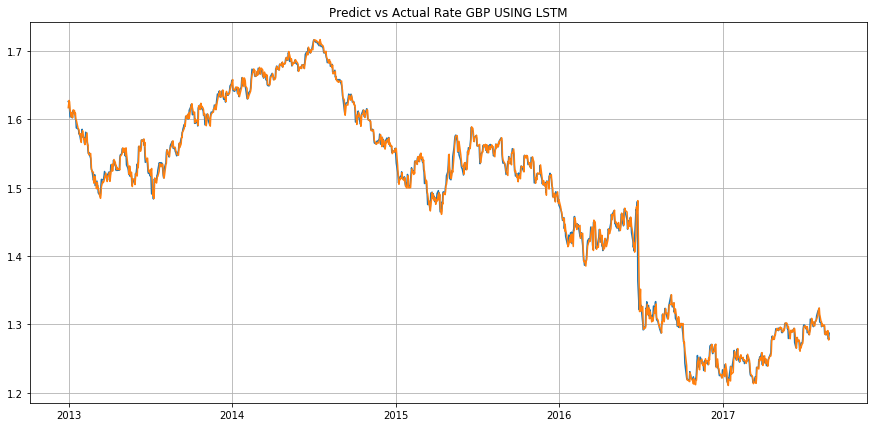

In [271]:
plt.figure(figsize=(15, 7))
plt.plot(actual_ser)
plt.plot(pred_ser)
plt.title('Predict vs Actual Rate GBP USING LSTM')
plt.grid(True)
plt.show()

In [275]:
# calculate RMSE
from math import sqrt
rmse = sqrt(mean_squared_error(actual_ser, pred_ser))
print('LSTM RMSE: %.3f' % rmse)

LSTM RMSE: 0.009


In [276]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import cufflinks as cf
init_notebook_mode(connected=True)

prices = pd.DataFrame({'Predictions':plotlist[1], 'Real Prices':plotlist[2]},index=plotlist[0])
iplot(prices.iplot(asFigure=True,
                   kind='scatter',
                   xTitle='Date',
                   yTitle='GBP Rate',
                   title='GBP Rate Predictions'))

### 5.Facebook prophet

In [9]:
df_rate_fb = df.loc[(df['RXI$US_N.B.UK'] != 'ND'), ['RXI$US_N.B.UK']]

In [10]:
df_rate_fb.rename(columns={'RXI$US_N.B.UK':'GBP_RATE'}, inplace=True)

In [11]:
df_rate_fb.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11709 entries, 1971-01-04 to 2017-08-25
Data columns (total 1 columns):
GBP_RATE    11709 non-null object
dtypes: object(1)
memory usage: 183.0+ KB


In [ ]:
# df_rate_fb['timestamp'] = pd.to_datetime(df_rate_fb.index,unit='ms').date

In [12]:
df_rate_fb['GBP_RATE'] = pd.to_numeric(df_rate_fb['GBP_RATE'])

In [13]:
df_rate_fb.head()

GBP_RATE
Time Period          
1971-01-04     2.3938
1971-01-05     2.3949
1971-01-06     2.3967
1971-01-07     2.3963
1971-01-08     2.3972

In [14]:
df_rate_fb.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11709 entries, 1971-01-04 to 2017-08-25
Data columns (total 1 columns):
GBP_RATE    11709 non-null float64
dtypes: float64(1)
memory usage: 183.0 KB


In [15]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [16]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

# Initialize plotly
init_notebook_mode(connected=True)

In [17]:
def plotly_df(df, title=''):
    """Visualize all the dataframe columns as line plots."""
    common_kw = dict(x=df.index, mode='lines')
    data = [go.Scatter(y=df[c], name=c, **common_kw) for c in df.columns]
    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

In [18]:
plotly_df(df_rate_fb, title='Historical GBP Rates (daily)')

In [19]:
weekly_df = df_rate_fb.resample('W').apply(sum)

In [20]:
plotly_df(weekly_df, title='Historical GBP Rates (weekly)')

In [21]:
from fbprophet import Prophet

import logging
logging.getLogger().setLevel(logging.ERROR)

In [22]:
df_rate_fb['timestamp'] = pd.to_datetime(df_rate_fb.index,unit='ms').date

In [23]:
df_rate_fb = df_rate_fb.drop('timestamp', axis=1)

In [24]:
df_rate_fb = df_rate_fb.tz_localize('utc') # QUAN TRONG

In [25]:
df_rate_fb.head()

GBP_RATE
Time Period                        
1971-01-04 00:00:00+00:00    2.3938
1971-01-05 00:00:00+00:00    2.3949
1971-01-06 00:00:00+00:00    2.3967
1971-01-07 00:00:00+00:00    2.3963
1971-01-08 00:00:00+00:00    2.3972

In [26]:
df_fb = df_rate_fb.reset_index()

In [27]:
df_fb.head()

Time Period  GBP_RATE
0 1971-01-04 00:00:00+00:00    2.3938
1 1971-01-05 00:00:00+00:00    2.3949
2 1971-01-06 00:00:00+00:00    2.3967
3 1971-01-07 00:00:00+00:00    2.3963
4 1971-01-08 00:00:00+00:00    2.3972

In [28]:
df_fb.columns = ['ds', 'y']
df_fb.tail(n=3)

ds       y
11706 2017-08-23 00:00:00+00:00  1.2787
11707 2017-08-24 00:00:00+00:00  1.2802
11708 2017-08-25 00:00:00+00:00  1.2873

In [29]:
prediction_size = 30
train_df = df_fb[:-prediction_size]
train_df.head(n=3)

ds       y
0 1971-01-04 00:00:00+00:00  2.3938
1 1971-01-05 00:00:00+00:00  2.3949
2 1971-01-06 00:00:00+00:00  2.3967

In [30]:
train_df['ds'] = train_df['ds'].dt.tz_convert(None)

In [31]:
m = Prophet()
m.fit(train_df);

In [32]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

ds
11706 2017-08-11
11707 2017-08-12
11708 2017-08-13

In [33]:
future.size

11709

In [34]:
forecast = m.predict(future)
forecast.tail(n=3)

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
11706 2017-08-11  1.345798    1.241599    1.473218     1.345798     1.345798   
11707 2017-08-12  1.345675    1.199099    1.431016     1.345675     1.345675   
11708 2017-08-13  1.345553    1.198124    1.429637     1.345553     1.345553   

       additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
11706        0.015004              0.015004              0.015004  0.012749   
11707       -0.031571             -0.031571             -0.031571 -0.033512   
11708       -0.031832             -0.031832             -0.031832 -0.033512   

       weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
11706      0.012749      0.012749  0.002255      0.002255      0.002255   
11707     -0.033512     -0.033512  0.001940      0.001940      0.001940   
11708     -0.033512     -0.033512  0.001680      0.001680      0.001680   

       multiplicative_terms  multiplicative_terms_lower  \
11706                   0.0                         0.0   
11707                   0.0                         0.0   
11708                   0.0                         0.0   

       multiplicative_terms_upper      yhat  
11706                         0.0  1.360802  
11707                         0.0  1.314104  
11708                         0.0  1.313721

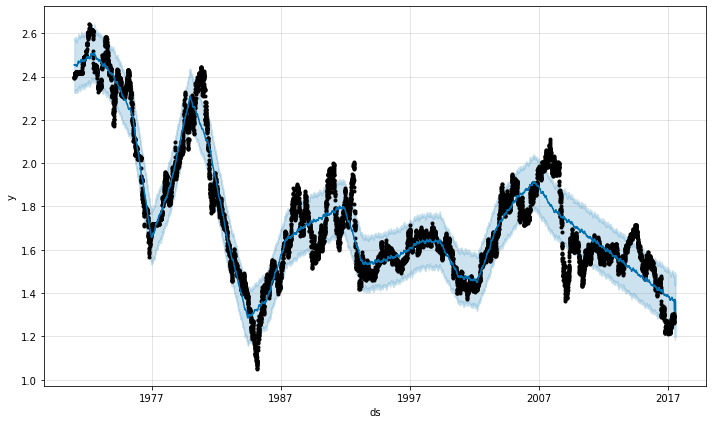

In [35]:
m.plot(forecast);

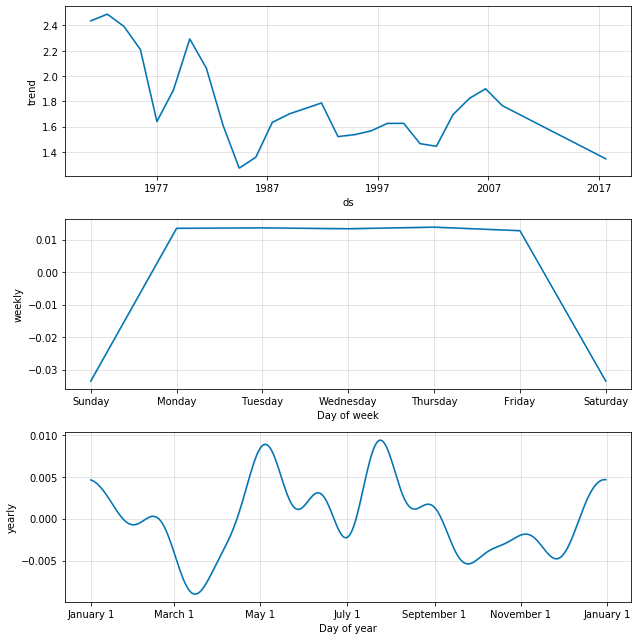

In [36]:
m.plot_components(forecast);

In [37]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


In [38]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [39]:
df_fb['ds'] = df_fb['ds'].dt.tz_convert(None)
cmp_df = make_comparison_dataframe(df_fb, forecast)
cmp_df.tail(n=3)

yhat  yhat_lower  yhat_upper       y
ds                                                  
2017-08-11  1.360802    1.241599    1.473218  1.2988
2017-08-12  1.314104    1.199099    1.431016     NaN
2017-08-13  1.313721    1.198124    1.429637     NaN

In [40]:
cmp_df.isnull().sum()

yhat           0
yhat_lower     0
yhat_upper     0
y             10
dtype: int64

In [41]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [42]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 4.73113916580302
MAE 0.0617294696862981


In [56]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""
    
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="#444"))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="#444"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='Posts'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, prediction_size, 100, 'New GBP rate on Medium')

In [44]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [45]:
train_df2 = train_df.copy().set_index('ds')

In [46]:
train_df2['y'], lambda_prophet = stats.boxcox(train_df2['y'])
train_df2.reset_index(inplace=True)

In [47]:
m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=prediction_size)
forecast2 = m2.predict(future2)

In [ ]:
cmp_df

In [49]:
y_fb_ser = forecast2

In [50]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast2[column] = inverse_boxcox(forecast2[column], lambda_prophet)

In [51]:
cmp_df2 = make_comparison_dataframe(df_fb, forecast2)
for err_name, err_value in calculate_forecast_errors(cmp_df2, prediction_size).items():
    print(err_name, err_value)

MAPE 5.633711118519645
MAE 0.07351216638954412


In [ ]:
cmp_df2

In [71]:
cmp_df.isnull().sum()

yhat          0
yhat_lower    0
yhat_upper    0
y             0
dtype: int64

In [72]:
cmp_df2.isnull().sum()

yhat          0
yhat_lower    0
yhat_upper    0
y             0
dtype: int64

In [70]:
cmp_df["y"].fillna(method='ffill', inplace = True)
cmp_df2["y"].fillna(method='ffill', inplace = True)

In [73]:
show_forecast(cmp_df, prediction_size, 100, 'No transformations')
show_forecast(cmp_df2, prediction_size, 100, 'Box–Cox transformation')

In [74]:
actual_ser = cmp_df['y']
pred_ser = cmp_df['yhat']

In [75]:
cmp_df['y'].isnull().sum()

0

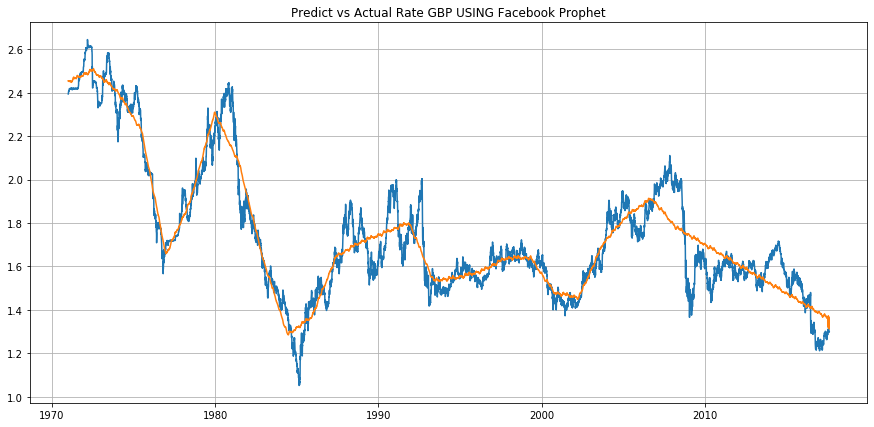

In [76]:
plt.figure(figsize=(15, 7))
plt.plot(actual_ser)
plt.plot(pred_ser)
plt.title('Predict vs Actual Rate GBP USING Facebook Prophet')
plt.grid(True)
plt.show()

In [337]:
# cmp_df['y'] = cmp_df['y'].fillna(0)

In [77]:
cmp_df.isnull().sum()

yhat          0
yhat_lower    0
yhat_upper    0
y             0
dtype: int64

In [78]:
# calculate RMSE
from math import sqrt
rmse = sqrt(mean_squared_error(actual_ser, pred_ser))
print('Facebook Prophet RMSE: %.3f' % rmse)

Facebook Prophet RMSE: 0.093


##  *** THE END ***